#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/27/2017
Updated to use the compound data corrected for extraction efficiency for all compounds.

In [2]:
if False:
    #this will work to reload whatever I had
    import dill
    dill.load_session('globalsave.pkl')

In [3]:
if False:
    %reset

In [4]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb
from sklearn import preprocessing
#from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler #redundant, fix later

import seaborn as sns

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [5]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.07.31_v1.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabNames = pd.read_csv(mtabFile,index_col = 'KEGG',usecols = ['KEGG','mtabNames'])
mtabNames.head(3)

,mtabNames
KEGG,
C00196,2-3-dihydroxybenzoic acid
C19675,2-3-dihydroxypropane1sulfonate
C08276,3-mercapto proprionate


In [6]:
#take out the extra columns: 
mtabData.drop(['extEff','mtabNames'],axis = 1,inplace = True)
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])

In [7]:
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,1.500000e-09,0.0,7.560000e-09,0.000000e+00,8.830000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,1.490000e-06,0.0,1.260000e-06,1.700000e-06,3.660000e-08,1.370000e-05,1.170000e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,0.000000e+00,0.0,1.150000e-07,2.140000e-07,0.000000e+00,6.080000e-07,6.060000e-07,1.500000e-09,1.230000e-09,2.170000e-09,1.410000e-10,2.190000e-09


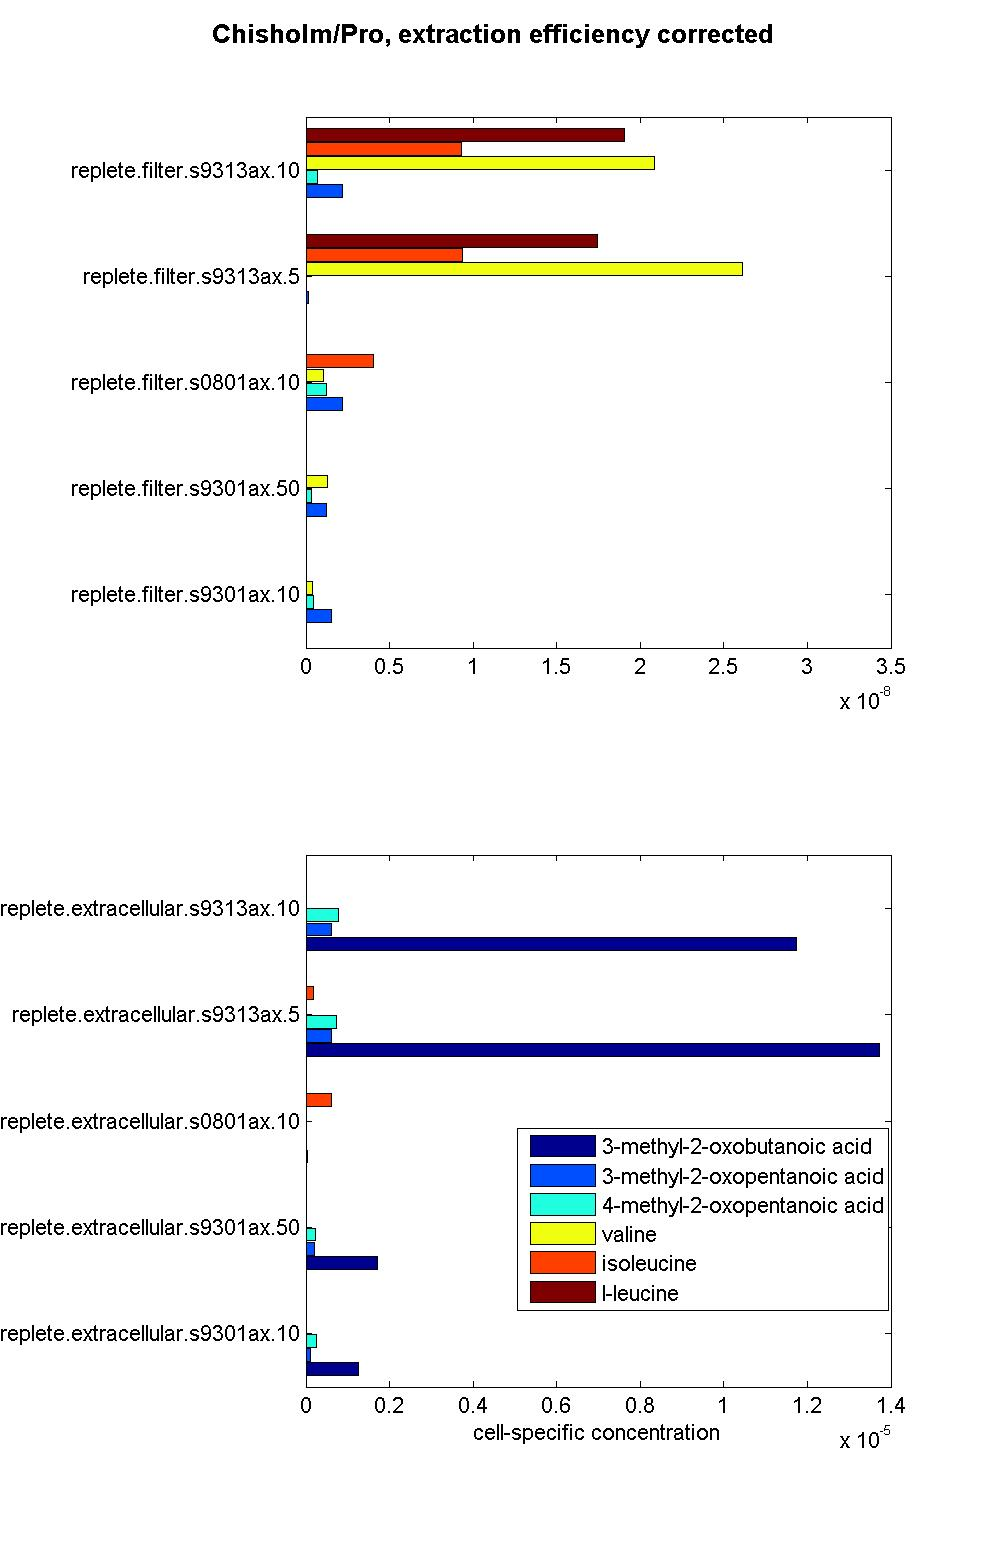

In [8]:
#read in the bar graph with the new acids (from MATLAB)
from IPython.display import Image
Image("Chisholm_Pro_newAcids.2017.04.27.jpg",width=300, height=300)

Setup a few useful functions
---

In [8]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [9]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [10]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [11]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [12]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimMap(importString):
    export_trimMap = []
    current_section = None
    for line in importString.rstrip().split("\n"):
        r = line.find('map')
        tp = line[r : r+9]
        export_trimMap.append(tp)
    return export_trimMap

#trim a pathway/compound list
def trimCompounds(cpdString):
    export_trimCpds = []
    current_section = None
    for line in cpdString.rstrip().split("\n"):
        #print(line)
        r = line.find('cpd')
        tp = line[r + 4 : len(line)]
        export_trimCpds.append(tp)
    return export_trimCpds

#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimGenes(geneString):
    export_trimGenes = []
    current_section = None
    for line in geneString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        r = line.find('ko:')
        tp = line[r+3 : r+9]
        export_trimGenes.append(tp)
    return export_trimGenes

In [13]:
#bring in the plotting functions
import plotByGroup
#import fxn_plotPathway #with ratios...but other errors in there
import fxn_plotPathway_v2
##if I make a change, have to reload the function(s):
# reload(fxn_plotPathway)

In [14]:
#go read in the file from KEGG
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 4/18/2017
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof)
    
prunedBRITE = allBRITE.dropna()
prunedBRITE.head(3)

,map,A,B,C,wholeThing
10,01100,Metabolism,Global and overview maps,Metabolic pathways,C 01100 Metabolic pathways\n
11,01110,Metabolism,Global and overview maps,Biosynthesis of secondary metabolites,C 01110 Biosynthesis of secondary metaboli...
12,01120,Metabolism,Global and overview maps,Microbial metabolism in diverse environments,C 01120 Microbial metabolism in diverse en...


In [16]:
prunedBRITE[prunedBRITE.loc[:,'map']=='00410'] #check one

,map,A,B,C,wholeThing
81,00410,Metabolism,Metabolism of other amino acids,beta-Alanine metabolism,C 00410 beta-Alanine metabolism\n


In [17]:
prunedBRITE[prunedBRITE.loc[:,'B']=='Amino acid metabolism'] #check one

,map,A,B,C,wholeThing
66,00250,Metabolism,Amino acid metabolism,"Alanine, aspartate and glutamate metabolism","C 00250 Alanine, aspartate and glutamate m..."
67,00260,Metabolism,Amino acid metabolism,"Glycine, serine and threonine metabolism","C 00260 Glycine, serine and threonine meta..."
68,00270,Metabolism,Amino acid metabolism,Cysteine and methionine metabolism,C 00270 Cysteine and methionine metabolism\n
69,00280,Metabolism,Amino acid metabolism,"Valine, leucine and isoleucine degradation","C 00280 Valine, leucine and isoleucine deg..."
70,00290,Metabolism,Amino acid metabolism,"Valine, leucine and isoleucine biosynthesis","C 00290 Valine, leucine and isoleucine bio..."
71,00300,Metabolism,Amino acid metabolism,Lysine biosynthesis,C 00300 Lysine biosynthesis\n
72,00310,Metabolism,Amino acid metabolism,Lysine degradation,C 00310 Lysine degradation\n
73,00220,Metabolism,Amino acid metabolism,Arginine biosynthesis,C 00220 Arginine biosynthesis\n
74,00330,Metabolism,Amino acid metabolism,Arginine and proline metabolism,C 00330 Arginine and proline metabolism\n
75,00340,Metabolism,Amino acid metabolism,Histidine metabolism,C 00340 Histidine metabolism\n


In [18]:
#only want 'metabolism' biochemical pathways
findM = prunedBRITE.loc[(prunedBRITE['A'] == 'Metabolism')]
findU = findM.loc[:,'B']

#really not that many pathway groups
findU.unique()

array(['Global and overview maps', 'Carbohydrate metabolism',
       'Energy metabolism', 'Lipid metabolism', 'Nucleotide metabolism',
       'Amino acid metabolism', 'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [19]:
unMetabolismGroups = findU.unique()
unMetabolismGroups = np.delete(unMetabolismGroups,(0),axis=0) #skip over the global and overview maps

In [20]:
#let's think about what we actually want to plot...
list(mtabPruned)

['Plimited_extracellular_s9301ax_50',
 'Plimited_filter_s9301ax_50',
 'replete_extracellular_s9301ax_10',
 'replete_extracellular_s9301ax_50',
 'replete_extracellular_s0801ax_10',
 'replete_extracellular_s9313ax_5',
 'replete_extracellular_s9313ax_10',
 'replete_filter_s9301ax_10',
 'replete_filter_s9301ax_50',
 'replete_filter_s0801ax_10',
 'replete_filter_s9313ax_5',
 'replete_filter_s9313ax_10']

Plot the metabolite concentration by group
---

In [21]:
#can plot one at a time (change strain, 3-digit KEGG code, and light level)
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_10']
fxn_plotPathway_v2.gatherDetails('pmg00020','filter_plots',useCO,CO_values)

CO_values = mtabPruned.loc[:,'replete_extracellular_s9301ax_10']
fxn_plotPathway_v2.gatherDetails('pmg00020','extracellular_plots',useCO,CO_values)

In [22]:
#can plot one at a time
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s9313ax_5']
fxn_plotPathway_v2.gatherDetails('pmt00020','filter_plots',useCO,CO_values)

CO_values = mtabPruned.loc[:,'replete_extracellular_s9313ax_5']
fxn_plotPathway_v2.gatherDetails('pmt00020','extracellular_plots',useCO,CO_values)

In [23]:
#can plot one at a time
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s0801ax_10']
fxn_plotPathway_v2.gatherDetails('prm00020','filter_plots',useCO,CO_values)

CO_values = mtabPruned.loc[:,'replete_extracellular_s0801ax_10']
fxn_plotPathway_v2.gatherDetails('prm00020','extracellular_plots',useCO,CO_values)

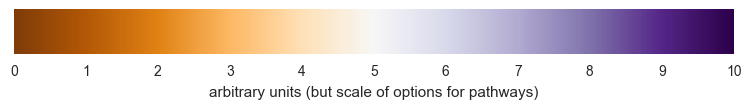

In [24]:
#...use the colorbar shown below for the pathway maps, though will set green to zero
import colorbar_only
#reload(colorbar_only)
#this will be the range of colors in the pathway maps (PDF files) (not green bc genes are green)

In [25]:
#plot the pathway maps for one strain and one set of data
oneStrain = 'pmg'
useCO = mtabPruned.index

#set CO_values only for the pathway maps...(only plot one group at a time there)
#CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_50']  

if False:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway_v2.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)
                

In [26]:
#plot the pathway maps for one strain and one set of data
oneStrain = 'pmt'
useCO = mtabPruned.index

#set CO_values only for the pathway maps...(only plot one group at a time there)
#CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
CO_values = mtabPruned.loc[:,'replete_filter_s9313ax_10']  

if False:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway_v2.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)

In [27]:
#plot the pathway maps for one strain and one set of data
oneStrain = 'prm'
useCO = mtabPruned.index

#set CO_values only for the pathway maps...(only plot one group at a time there)
#CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
CO_values = mtabPruned.loc[:,'replete_filter_s0801ax_10']  

if False:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway_v2.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)

In [28]:
oneStrain

'prm'

In [29]:
##ACK...there is an error in the next cell because it relies on oneStrain that 
#is set by the cell above...oops. So all plots generated by the next cell are only for the one strain

In [30]:
#plot the data for each type of metabolism map (all strains); this takes a while; set to True to run this section
if False:
    useCO = mtabPruned.index
    for oneGroup in unMetabolismGroups:
        #next line will make the color maps for each group: purple = low; green = high
        #these are scaled data, from 0 to 1 
        scaled = True
        plotByGroup.plotGroup_clusterT(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain,scaled)

Only want to plot the Amino Acid Metabolism for the IMBER meeting poster
----

#### 9/24/2018 - found an issue in labeling the amino acid plots...for reasons I don't understand, the labeling is getting shuffled in the code I used for IMBER...so the actual plots do not match the data bc the metabolite names are in the wrong place
----

In [16]:
useCO = mtabPruned.index

In [32]:
oneGroup = 'Amino acid metabolism'

shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
onePath = shortList.loc[:,'map']
onePath_ann = []
for item in onePath:
    onePath_ann.append('ko' + item)

In [33]:
gatherGroup = pd.DataFrame()
for one in onePath_ann:
    mCpds = set(getCfrom_ko(one))
    ProData= set(useCO)
    handh = mCpds.intersection(ProData)

    for cpd in handh:
    #print(cpd)
    #pdb.set_trace()
        tm = mtabPruned.loc[cpd,:]
        if (cpd in gatherGroup.index): 
            pass
        else: #only add the mtab if it is new...can have mtabs in multiple pathways
            gatherGroup = gatherGroup.append(tm)

In [34]:
#let's get rid of the zeros first...
gatherGroup.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s9313ax_10,replete_extracellular_s9313ax_5,replete_filter_s0801ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s9313ax_10,replete_filter_s9313ax_5
C00334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.190000e-08,2.100000e-08,2.200000e-08,5.210000e-08,5.380000e-08
C00064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.640000e-08,2.490000e-09,0.000000e+00,4.830000e-09,0.000000e+00
C00352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.110000e-08,5.210000e-08,2.510000e-08


In [35]:
#first, by KEGG number, pick the amino acids I want to plot
step1 = gatherGroup.ix[('C00062','C00049','C00025','C00123','C00079'),]

In [36]:
#this is the amino acids that do inhibit growth (Chisholm PhD student)
#first, by KEGG number, pick the amino acids I want to plot
step1 = gatherGroup.ix[('C00064','C00148','C00188','C00183','C00073','C00078','C00082','C00407','C00065','C00097'),]

In [37]:
#gatherGroup.ix[('C00079')]

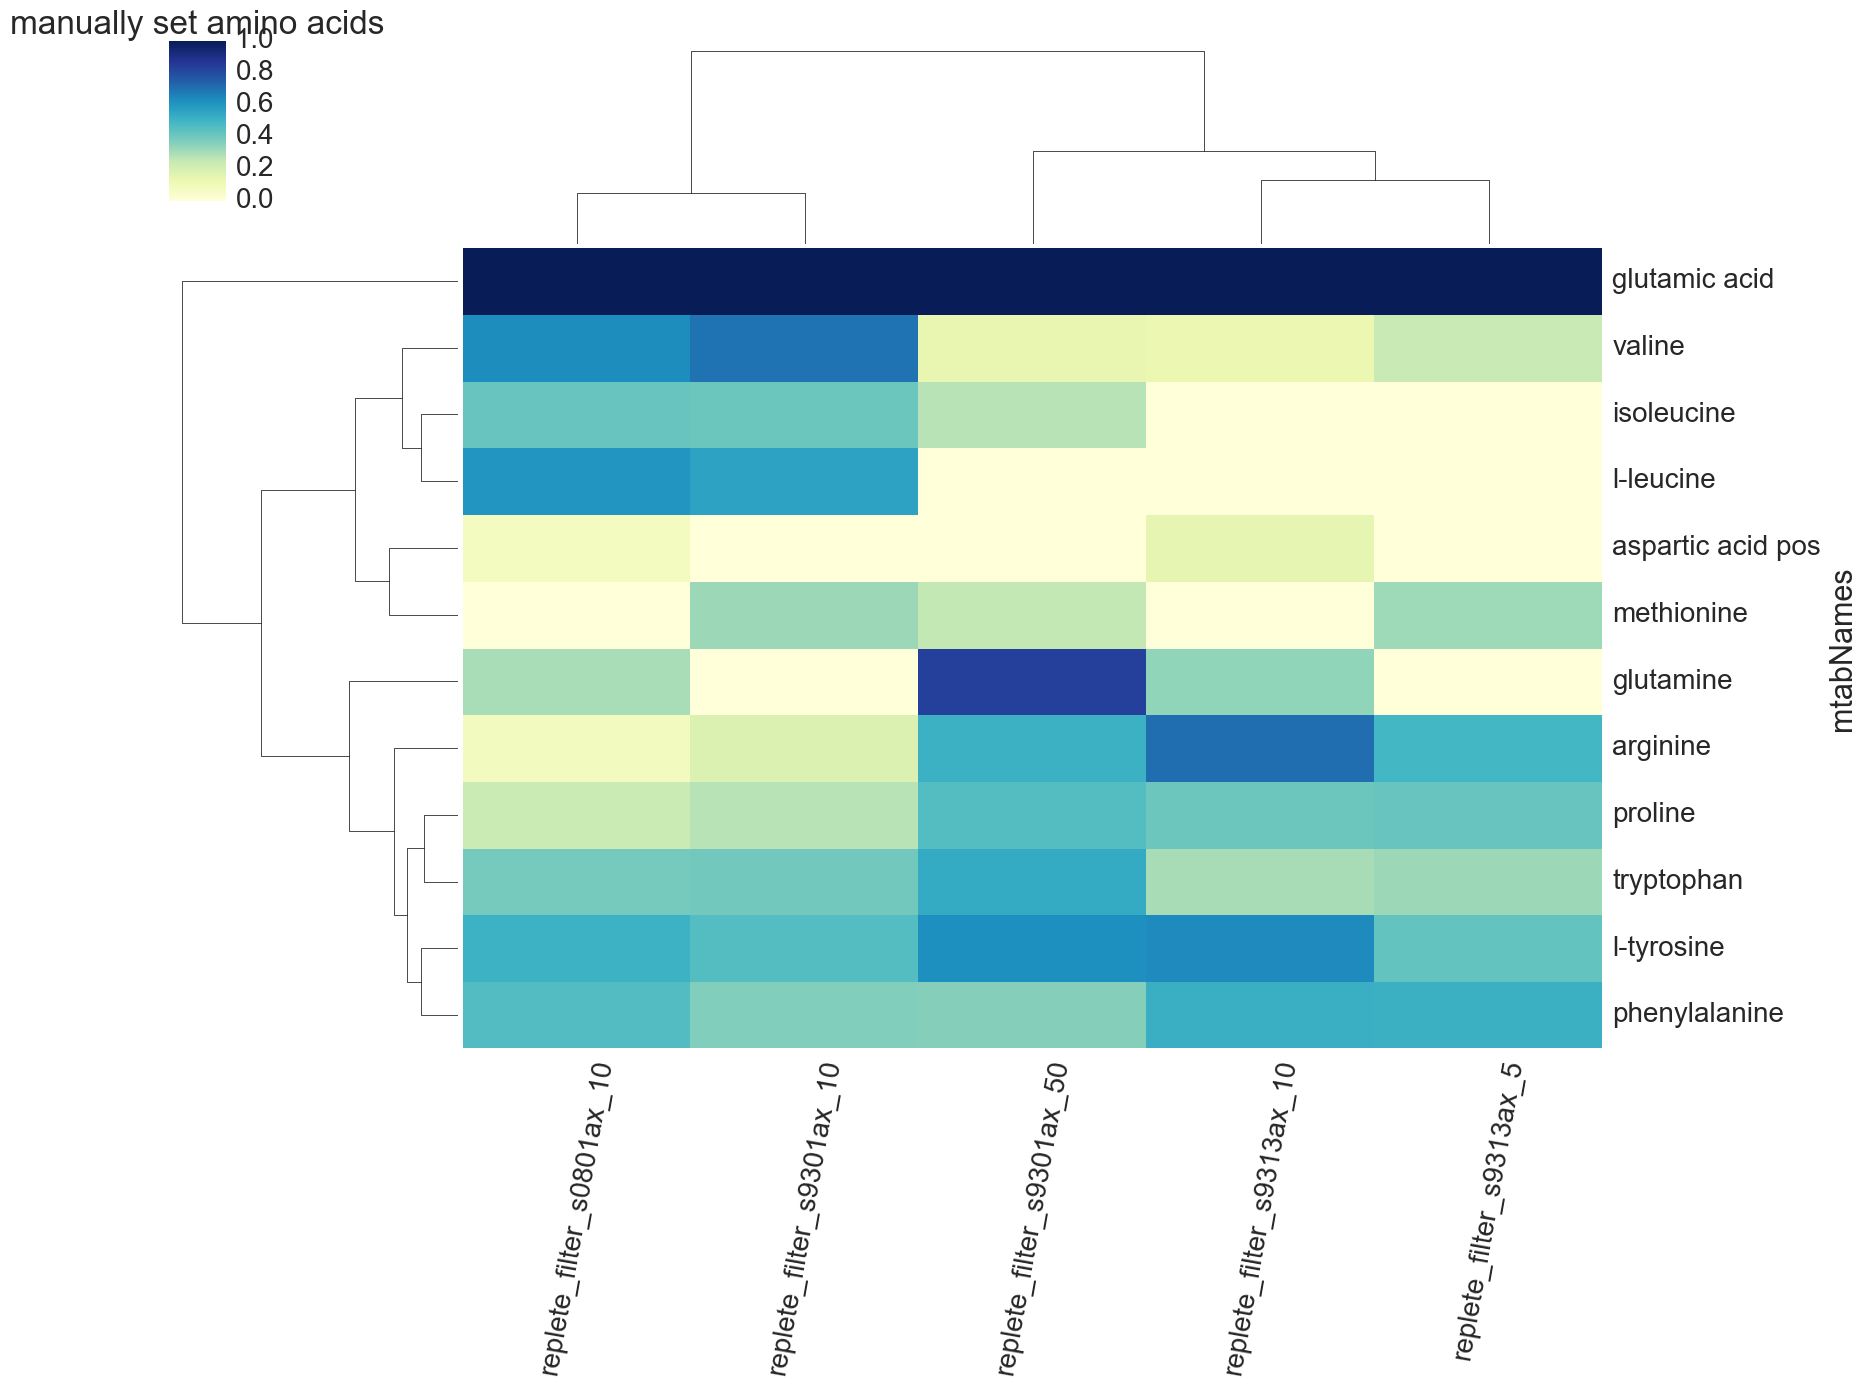

In [94]:
#what if I just look at the amino acids and ignore the precursors
#first, by KEGG number, pick the amino acids I want to plot
#step1 = gatherGroup.ix[('C00062','C00049','C00025','C00123','C00079','C00064','C00148','C00188','C00183','C00073','C00078','C00082','C00407','C00065','C00097'),]
step1 = gatherGroup.ix[('C00049','C00064','C00148','C00188','C00082','C00407','C00065','C00025','C00123','C00079','C00062','C00183','C00073','C00078','C00097'),]

#only consider the replete cultures
justAA = step1.filter(regex = 'replete_filter')
justAA = justAA.loc[(justAA!=0).any(1)]

#for scaling:
#if axis = 0, normalized by scale by row (metabolite)
#if axis = 1 normalized by scale by column (sample)
###be careful with the transpose
#first set up the data
data_sqrt = np.sqrt(justAA)
scaled = MinMaxScaler(copy = True).fit_transform(data_sqrt)
#scaled = RobustScaler(copy = True).fit_transform(data_sqrt) #not helpful, but leave here so I remember the syntax

df = pd.DataFrame(scaled,columns = justAA.columns,index = justAA.index)
#change from a KEGG name to metabolite name
useNames = df.index
output = mtabNames.loc[useNames,'mtabNames']
df.index = output
#df

#then make the clustermap
sns.set(font_scale = 2)
g = sns.clustermap(df,cmap = 'YlGnBu',method = 'ward',metric = 'cityblock')
#ax = g.ax_heatmap
#ax.set_xlabel(output)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.set_xticklabels(df.columns),rotation =80) #if the number is any smaller, the rotation shifts labels too far
plt.title('manually set amino acids')
fig = plt.gcf()
fig.set_size_inches(18.5, 13)
g.savefig('justAminoAcids_filters' + '.pdf', dpi=100)
plt.show() #this will suppress all the rows of 'None'

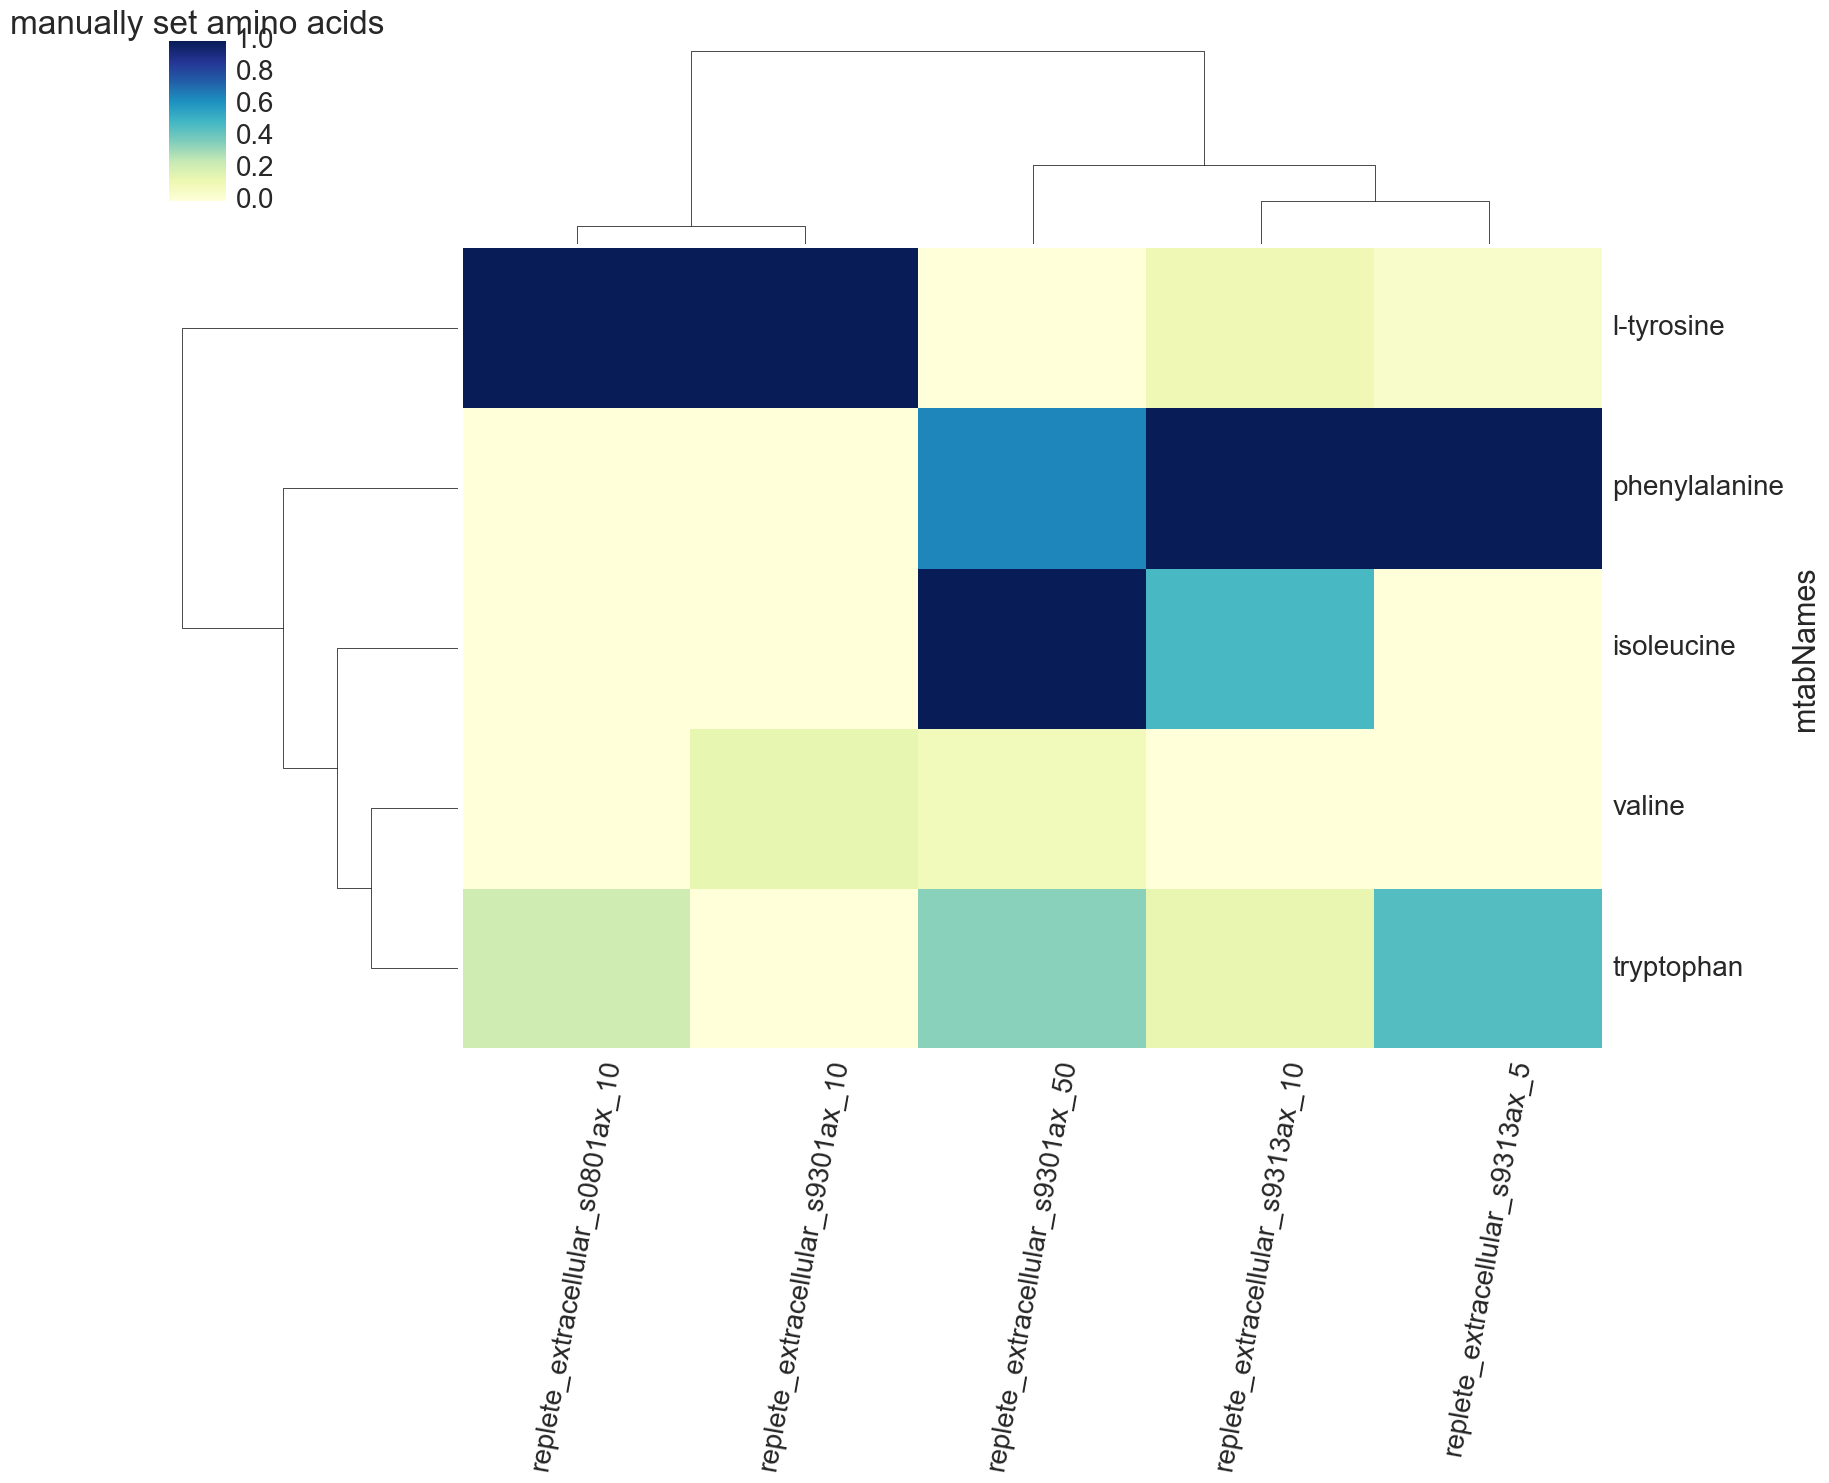

In [95]:
#what if I just look at the amino acids and ignore the precursors
#first, by KEGG number, pick the amino acids I want to plot
#step1 = gatherGroup.ix[('C00062','C00049','C00025','C00123','C00079','C00064','C00148','C00188','C00183','C00073','C00078','C00082','C00407','C00065','C00097'),]
step1 = gatherGroup.ix[('C00049','C00064','C00148','C00188','C00082','C00407','C00065','C00025','C00123','C00079','C00062','C00183','C00073','C00078','C00097'),]

#only consider the replete cultures
justAA = step1.filter(regex = 'replete_extracellular')
justAA = justAA.loc[(justAA!=0).any(1)]

#for scaling:
#if axis = 0, normalized by scale by row (metabolite)
#if axis = 1 normalized by scale by column (sample)
###be careful with the transpose
#first set up the data
data_sqrt = np.sqrt(justAA)
scaled = MinMaxScaler(copy = True).fit_transform(data_sqrt)
#scaled = RobustScaler(copy = True).fit_transform(data_sqrt) #not helpful, but leave here so I remember the syntax

df = pd.DataFrame(scaled,columns = justAA.columns,index = justAA.index)
#change from a KEGG name to metabolite name
useNames = df.index
output = mtabNames.loc[useNames,'mtabNames']
df.index = output
#df

#then make the clustermap
sns.set(font_scale = 2)
g = sns.clustermap(df,cmap = 'YlGnBu',method = 'ward',metric = 'cityblock')
#ax = g.ax_heatmap
#ax.set_xlabel(output)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.set_xticklabels(df.columns),rotation =80) #if the number is any smaller, the rotation shifts labels too far
plt.title('manually set amino acids')
fig = plt.gcf()
fig.set_size_inches(18.5, 13)
g.savefig('justAminoAcids_extracellular' + '.pdf', dpi=100)
plt.show() #this will suppress all the rows of 'None'

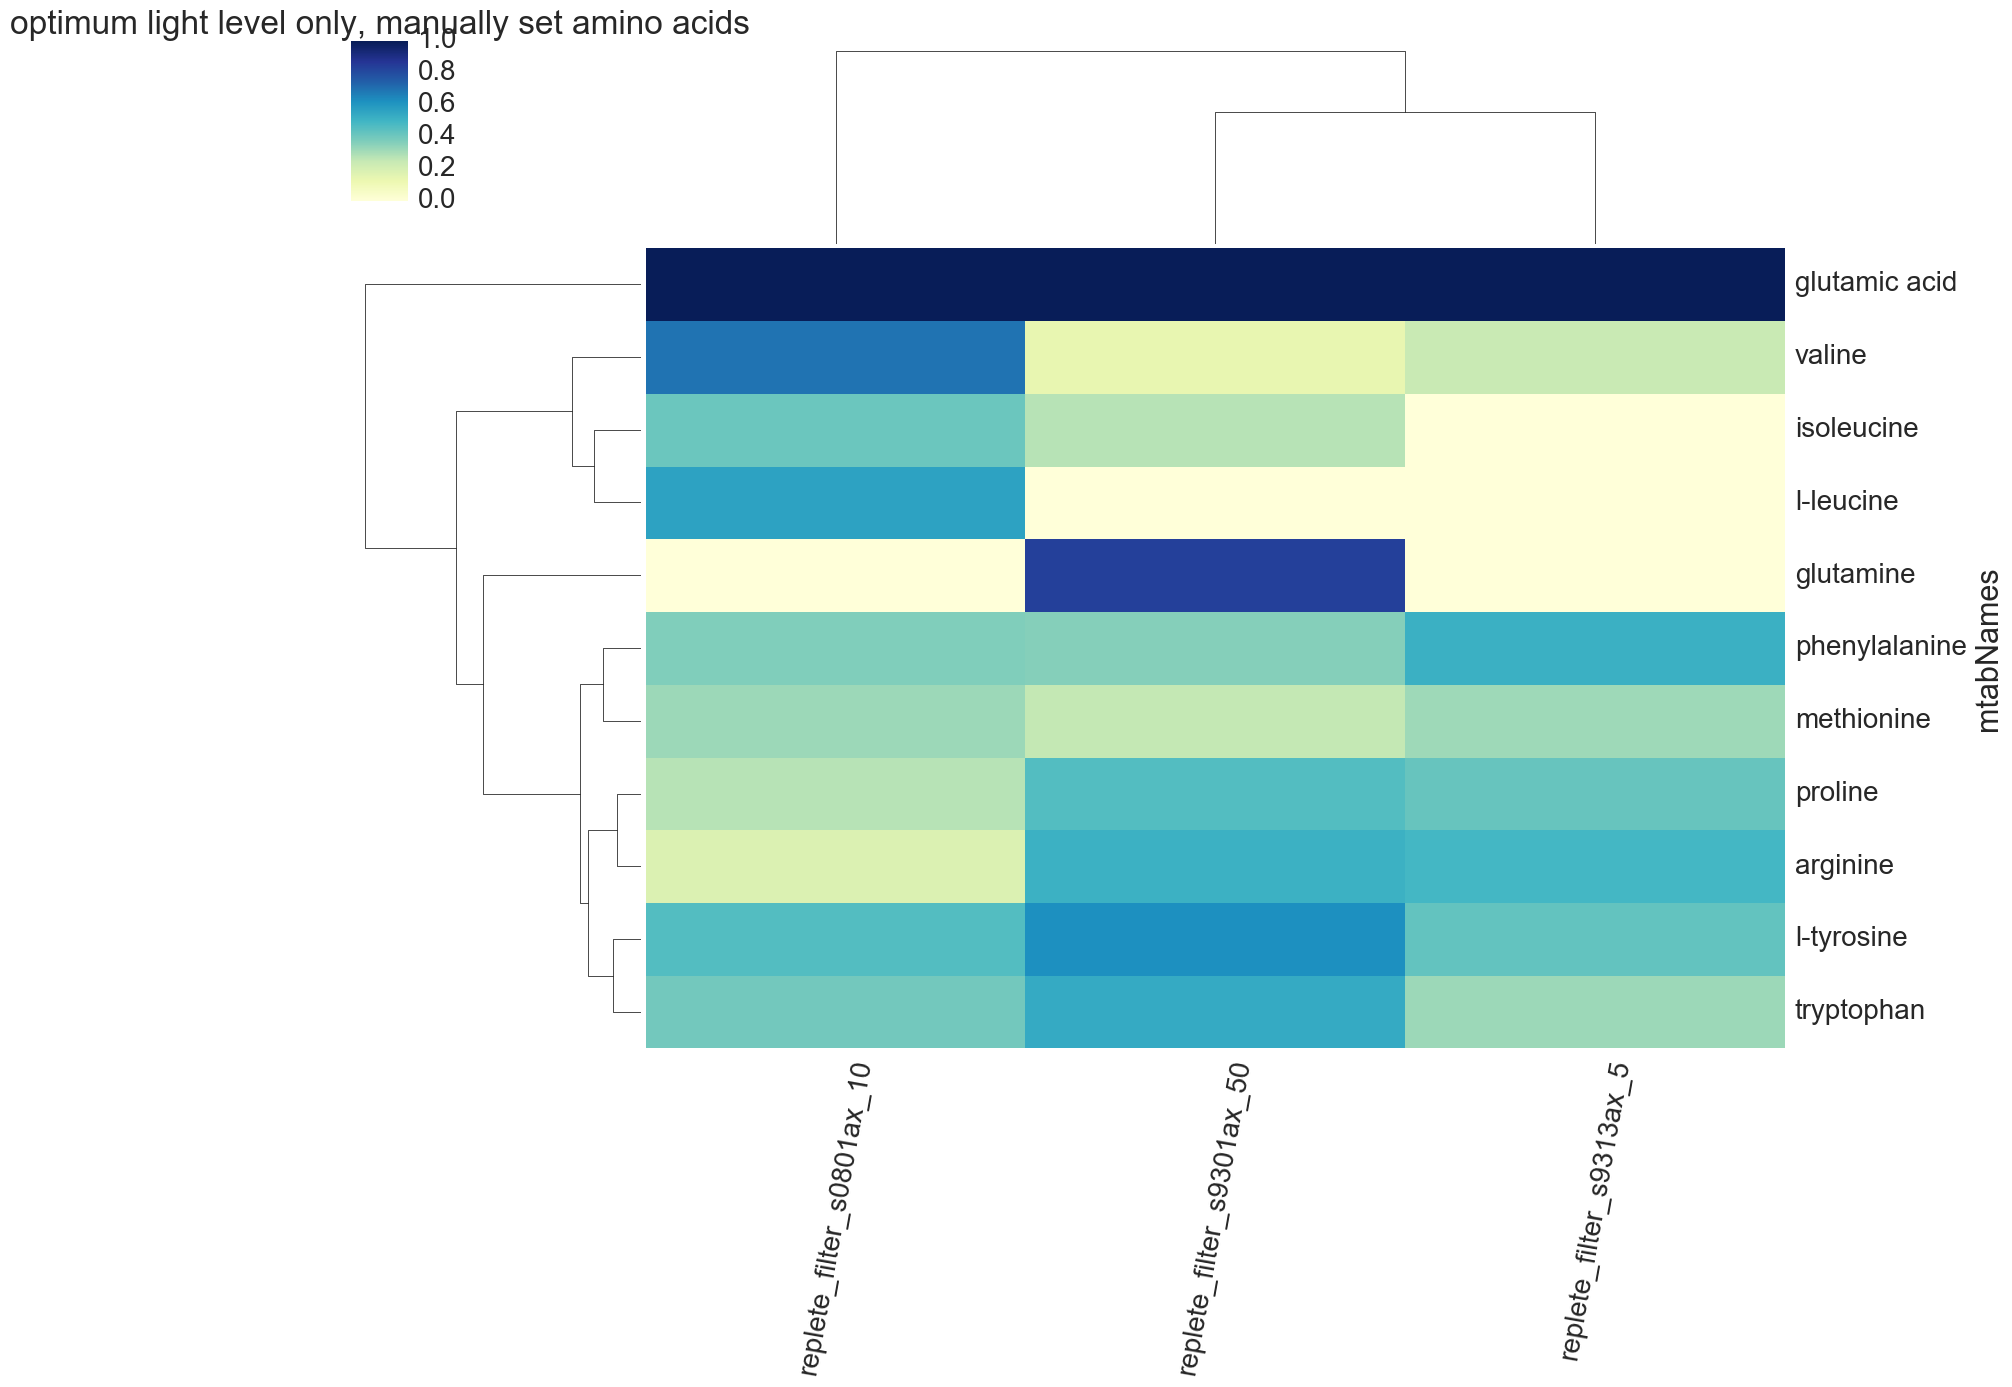

In [111]:
#what if I just look at the amino acids and ignore the precursors
#first, by KEGG number, pick the amino acids I want to plot
#step1 = gatherGroup.ix[('C00062','C00049','C00025','C00123','C00079','C00064','C00148','C00188','C00183','C00073','C00078','C00082','C00407','C00065','C00097'),]
step1 = gatherGroup.ix[('C00049','C00064','C00148','C00188','C00082','C00407','C00065','C00025','C00123','C00079','C00062','C00183','C00073','C00078','C00097'),]

#only consider the replete cultures
#no spaces after the pipe (|)
justAA = step1.filter(regex = 'replete_filter_s0801ax_10|replete_filter_s9301ax_50|replete_filter_s9313ax_5')
justAA = justAA.loc[(justAA!=0).any(1)]

#for scaling:
#if axis = 0, normalized by scale by row (metabolite)
#if axis = 1 normalized by scale by column (sample)
###be careful with the transpose
#first set up the data
data_sqrt = np.sqrt(justAA)
scaled = MinMaxScaler(copy = True).fit_transform(data_sqrt)
#scaled = RobustScaler(copy = True).fit_transform(data_sqrt) #not helpful, but leave here so I remember the syntax

df = pd.DataFrame(scaled,columns = justAA.columns,index = justAA.index)
#change from a KEGG name to metabolite name
useNames = df.index
output = mtabNames.loc[useNames,'mtabNames']
df.index = output
#df

#then make the clustermap
sns.set(font_scale = 2)
g = sns.clustermap(df,cmap = 'YlGnBu',method = 'ward',metric = 'cityblock')
#ax = g.ax_heatmap
#ax.set_xlabel(output)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.set_xticklabels(df.columns),rotation =80) #if the number is any smaller, the rotation shifts labels too far
plt.title('optimum light level only, manually set amino acids')
fig = plt.gcf()
fig.set_size_inches(18.5, 13)
g.savefig('optimumLight_AminoAcids_filters' + '.pdf', dpi=100)
plt.show() #this will suppress all the rows of 'None'

In [122]:
# #this was the code used for the IMBER meeting (October 2017)
# #9/24/2018 note: the labels are wrong on the IMBER poster! I don't understand why, but they are
# #for the poster (and probably the paper), only want replete samples and do not want mtabs that are all zero
# forPoster = gatherGroup.filter(regex = 'replete')
# forPoster=forPoster.loc[(forPoster!=0).any(1)]

# scaled = preprocessing.minmax_scale(forPoster,feature_range=(0,1),axis = 1,copy=True)
# df = pd.DataFrame(scaled,columns = forPoster.columns,index = forPoster.index) 

# #useNames = df.T.columns
# #output = mtabNames.loc[useNames,'mtabNames']
# sns.set(font_scale = 2)
# g = sns.clustermap(df.T,cmap = 'YlGnBu',method = 'ward',metric = 'cityblock')
# plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
# #plt.setp(g.ax_heatmap.set_xticklabels(labels = output),rotation =90) somehow the error in labeling comes in here
# plt.title(oneGroup)
# fig = plt.gcf()
# fig.set_size_inches(18.5, 13)
# #g.savefig('workingPoster_noRenaming_' + oneGroup + '.pdf', dpi=100)
# plt.show() #this will suppress all the rows of 'None'

In [ ]:
# #plot the data for each type of metabolism map (all strains)
# useCO = mtabPruned.index
# for oneGroup in unMetabolismGroups:
#     #next line will make the color maps for each group: purple = low; green = high
#     #these are scaled data, from 01 to 1 
#     scaled = True
#     plotByGroup.plotGroup_clusterT(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain,scaled)

Use the information at KEGG to find the theoretical overlap across the strains
----

In [26]:
#use biopython/KEGG module to get the information
pmgPathways = kegg_list('pathway','pmg').read()
pmgTrim = trimPath(pmgPathways)

prmPathways = kegg_list('pathway','prm').read()
prmTrim = trimPath(prmPathways)

pmtPathways = kegg_list('pathway','pmt').read()
pmtTrim = trimPath(pmtPathways)

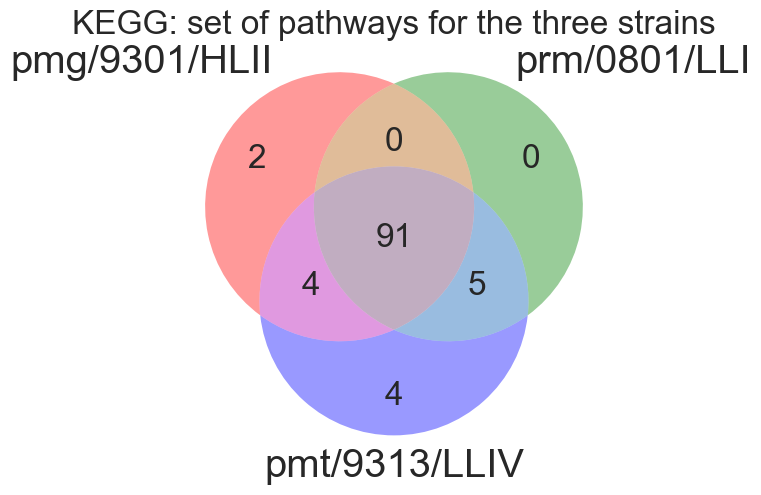

In [27]:
venn3_unweighted(subsets = (set(pmgTrim),set(prmTrim),set(pmtTrim)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of pathways for the three strains')
plt.savefig('Pro_pathways.png')

In [28]:
#pull the full set of compounds for each strain...
#have to loop through the genes because the KEGG / REST code will not do this 
#pull the full set of genes for each strain...
pmtGenes = trimGenes(kegg_link("ko","pmt").read())
pmgGenes = trimGenes(kegg_link("ko","pmg").read())
prmGenes = trimGenes(kegg_link("ko","prm").read())

In [29]:
#setup the strings to match first
rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190

pmg_countCpd = []
pmg_countGene = []
pmg_countRxn = []
        
for gen in pmgGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmg_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmg_countCpd.append(m2) 
                    pmg_countGene.append(gen)

In [30]:
pmt_countCpd = []
pmt_countGene = []
pmt_countRxn = []

for gen in pmtGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmt_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmt_countCpd.append(m2) 
                    pmt_countGene.append(gen)

In [31]:
prm_countCpd = []
prm_countGene = []
prm_countRxn = []

for gen in prmGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            prm_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    prm_countCpd.append(m2) 
                    prm_countGene.append(gen)

Consider the overlap in compounds among the three strains
---

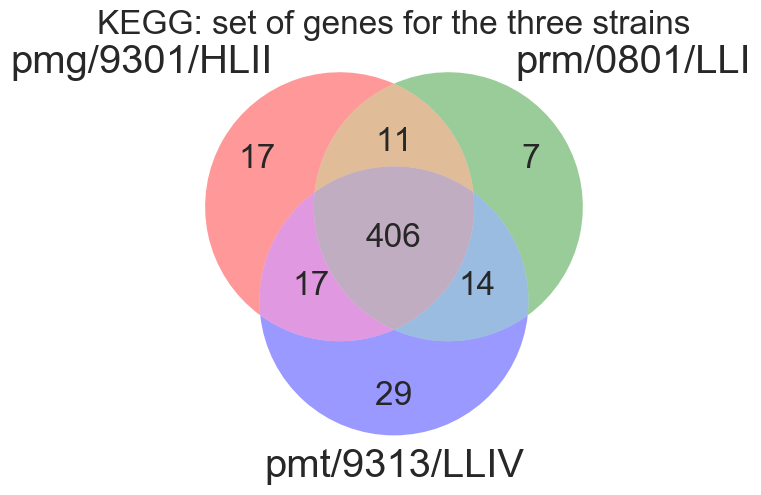

In [32]:
v = venn3_unweighted(subsets = (set(pmg_countGene),set(prm_countGene),set(pmt_countGene)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of genes for the three strains')
#plt.savefig('Pro_genes.png')

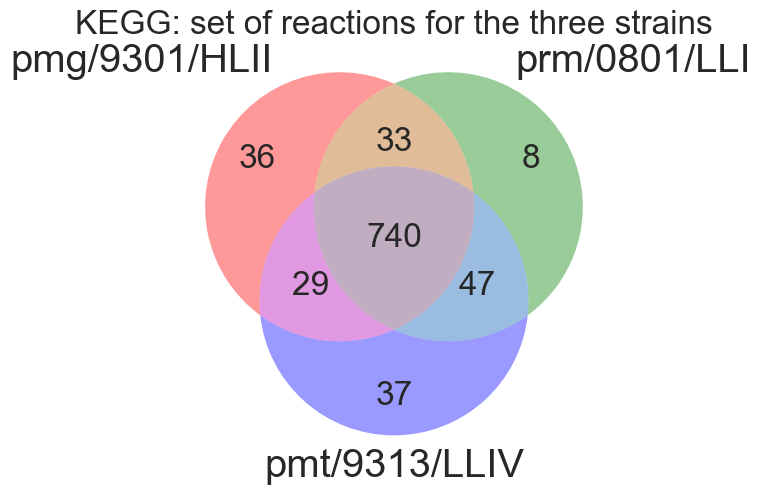

In [33]:
v = venn3_unweighted(subsets = (set(pmg_countRxn),set(prm_countRxn),set(pmt_countRxn)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of reactions for the three strains')
#plt.show() #don't do this...this creates a new figure
#plt.savefig('Pro_reactions.png')

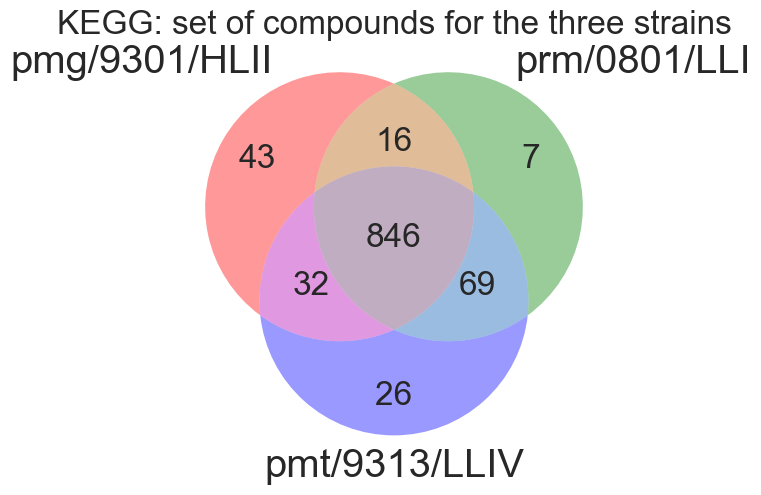

In [34]:
venn3_unweighted(subsets = (set(pmg_countCpd),set(prm_countCpd),set(pmt_countCpd)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of compounds for the three strains')
plt.savefig('Pro_cpds.png')

In [35]:
#what are the differences?
rxnString = set(prm_countRxn) - (set(pmg_countRxn)| set(pmt_countRxn))
#rxnString = set(pmg_countRxn) - (set(prm_countRxn)| set(pmt_countRxn))
#rxnString = set(pmt_countRxn) - (set(prm_countRxn)| set(pmg_countRxn))
#set(pmg_countGene) & set(prm_countGene)- set(pmt_countGene)
rxnString.pop()

'R00956'

In [36]:
kegg_get('R00956').read() #get information about a reaction

'ENTRY       R00956                      Reaction\nNAME        CTP:alpha-D-glucose-1-phosphate cytidylyltransferase\nDEFINITION  CTP + D-Glucose 1-phosphate <=> Diphosphate + CDP-glucose\nEQUATION    C00063 + C00103 <=> C00013 + C00501\nRCLASS      RC00002  C00103_C00501\nENZYME      2.7.7.33\nPATHWAY     rn00500  Starch and sucrose metabolism\n            rn00520  Amino sugar and nucleotide sugar metabolism\n            rn01100  Metabolic pathways\nORTHOLOGY   K00978  glucose-1-phosphate cytidylyltransferase [EC:2.7.7.33]\nDBLINKS     RHEA: 18216\n///\n'

In [37]:
# cpdString = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd) #in all three.
#what are the compounds unique to each strain? Change the logic as needed.
cpdString = set(pmg_countCpd) - (set(prm_countCpd)| set(pmt_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C04712	(7R)-7-(5-Carboxy-5-oxopentanoyl)aminocephalosporinate

cpd:C01146	2-Hydroxy-3-oxopropanoate; Tartronate semialdehyde

cpd:C03440	cis-4-Hydroxy-D-proline

cpd:C03564	1-Pyrroline-2-carboxylate; 1-Pyrroline-2-carboxylic acid; Delta1-Pyrroline 2-carboxylate; 1-Pyrroline 2-carboxylate

cpd:C03771	5-Guanidino-2-oxopentanoate; 5-Guanidino-2-oxo-pentanoate; 2-Oxo-5-guanidinopentanoate; 2-Oxo-5-guanidino-pentanoate; 2-Oxoarginine

cpd:C00511	Acrylic acid; Propenoate; Acrylate; 2-Propenoic acid; Vinylformic acid

cpd:C05678	(2-Amino-1-hydroxyethyl)phosphonate; 1-Hydroxy-2-aminoethylphosphonate

cpd:C20267	4-Amino-5-aminomethyl-2-methylpyrimidine

cpd:C04282	1-Pyrroline-4-hydroxy-2-carboxylate

cpd:C01110	5-Amino-2-oxopentanoic acid; 5-Amino-2-oxopentanoate; 2-Oxo-5-amino-pentanoate; 2-Oxo-5-aminopentanoate; alpha-Keto-delta-aminopentanoate; 2-Oxo-5-aminovalerate

cpd:C01401	Alanine; 2-Aminopropionic acid; 2-Aminopropanoic acid

cpd:C04294	5-(2-Hydroxyethyl)-4-methylthiazole; 4-Methyl

In [38]:
# cpdString = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd) #in all three.
#what are the compounds unique to each strain? Change the logic as needed.
cpdString = set(pmt_countCpd) - (set(prm_countCpd)| set(pmg_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C00534	Pyridoxamine; PM

cpd:C00575	3',5'-Cyclic AMP; Cyclic adenylic acid; Cyclic AMP; Adenosine 3',5'-phosphate; Adenosine 3',5'-cyclic phosphate; cAMP

cpd:C08276	3-(Methylthio)propanoate; 3-(Methylthio)propionic acid; 3-Methylthiopropionate

cpd:C00245	Taurine; 2-Aminoethanesulfonic acid; Aminoethylsulfonic acid

cpd:C01180	4-Methylthio-2-oxobutanoic acid; 4-Methylthio-2-oxobutanoate; 2-Keto-4-methylthiobutyric acid; 2-Oxo-4-methylthiobutanoate; 2-Oxo-4-methylthiobutanoic acid

cpd:C04582	S-Methyl-5-thio-D-ribulose 1-phosphate

cpd:C00942	3',5'-Cyclic GMP; Guanosine 3',5'-cyclic monophosphate; Guanosine 3',5'-cyclic phosphate; Cyclic GMP; cGMP

cpd:C00468	Estrone; 3-Hydroxy-1,3,5(10)-estratrien-17-one

cpd:C00721	Dextrin

cpd:C00519	Hypotaurine; 2-Aminoethanesulfinic acid

cpd:C00647	Pyridoxamine phosphate; Pyridoxamine 5-phosphate; Pyridoxamine 5'-phosphate

cpd:C01170	UDP-N-acetyl-D-mannosamine; UDP-N-acetyl-alpha-D-mannosamine

cpd:C06125	Sulfatide; Galactosylceramide sulfat

In [17]:
#Do the simplest count first, is a compound in anything from each strain?
#match this to the figure from KEGG for the IMBER poster

#slight hack
set_9301 = set()
st = 's9301'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_9301.add(oneCpd)
        
        
set_0801 = set()
st = 's0801'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_0801.add(oneCpd)
        
set_9313 = set()
st = 's9313'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_9313.add(oneCpd)


In [18]:
# venn3_unweighted(subsets = (set(pmg_countCpd),set(prm_countCpd),set(pmt_countCpd)),set_labels = 
#                  ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
# plt.title('KEGG: set of compounds for the three strains')
# plt.savefig('Pro_cpds.png')

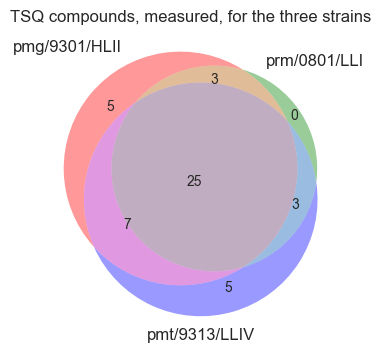

In [19]:
venn3([set_9301,set_0801,set_9313],set_labels = ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('TSQ compounds, measured, for the three strains')
plt.savefig('Pro_TSQmeasured_cpds.png')

In [ ]:
#hack, but Liz doesn't like the Venn diagram and wants a list of compounds...export the compounds as 
#KEGG numbers. Because I don't feel up to it, I will manually make this into a list of metabolite names
#4/19/2019

In [56]:
#did this multiple times and opened up next.csv in Excel after each time
import csv

all3 = (set(set_9313) & set(set_0801)) -  set(set_9301)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        
csvfile = "next.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in keep:
        writer.writerow([val])  

In [39]:
#remember - this is the theoretical overlap based on KEGG
all3 = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        #print(kegg_list(item).read())

In [19]:
#is a cpd in all three strains? or some lower number? ...only filter data here
cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0','s9301','s0801','s9313'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('filter_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            cpd_inNstrains.loc[oneCpd,st] = 1
    
    a = cpd_inNstrains.loc[oneCpd,strains].sum()

    if a == 3:
        cpd_inNstrains.loc[oneCpd,'in3'] = 1
    elif a == 2:
        cpd_inNstrains.loc[oneCpd,'in2'] = 1
    elif a == 1:
        cpd_inNstrains.loc[oneCpd,'in1'] = 1
    else: #will never have a=0 bc the if not r.empty statement
        cpd_inNstrains.loc[oneCpd,'in0'] = 1
        
sumCount = cpd_inNstrains.sum(axis=0)

In [41]:
r = cpd_inNstrains[cpd_inNstrains.loc[:,'in3'].gt(0)] #in 3...perhaps 'core' mtabs in Pro
for item in r.index:
    print(kegg_list(item).read())

cpd:C00671	(S)-3-Methyl-2-oxopentanoic acid; (S)-3-Methyl-2-oxopentanoate; (3S)-3-Methyl-2-oxopentanoic acid; (3S)-3-Methyl-2-oxopentanoate

cpd:C00233	4-Methyl-2-oxopentanoate; 2-Oxoisocaproate

cpd:C00020	AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00130	IMP; Inosinic acid; Inosine monophosphate; Inosine 5'-monophosphate; Inosine 5'-phosphate; 5'-Inosinate; 5'-Inosinic acid; 5'-Inosine monophosphate; 5'-IMP

cpd:C00051	Glutathione; 5-L-Glutamyl-L-cysteinylglycine; N-(N-gamma-L-Glutamyl-L-cysteinyl)glycine; gamma-L-Glutamyl-L-cysteinyl-glycine; GSH; Reduced glutathione

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphen

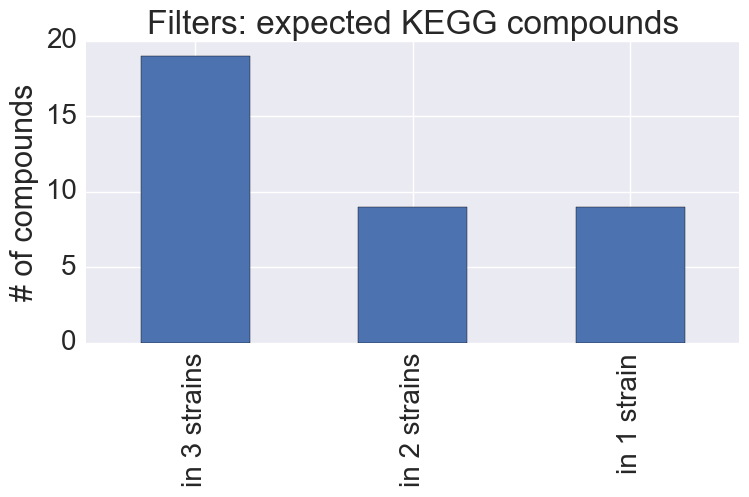

In [42]:
#remember - this is the subset of compounds I expect to find in all three strains...
#also...pre-screened to only be compounds we measured...this figure accounts for 
#anything with a value > 0
fig,axs = plt.subplots(1,1)
sumCount.loc[['in3','in2','in1']].plot(kind = 'bar')
axs.set_title('Filters: expected KEGG compounds')
axs.set_ylabel('# of compounds')
tLabel = ['in 3 strains','in 2 strains','in 1 strain']
axs.set_xticklabels(tLabel)
plt.tight_layout()
plt.savefig('nCompounds_filters.jpg')

Did we see what we expected based on the strain differences?
---

In [43]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s0801']):
        pass
    else:
        #is in the list for strain?
        if item in prm_countCpd:
            pass
        else:
            print(kegg_list(item).read())

In [44]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00719	Betaine; Trimethylaminoacetate; Glycine betaine; N,N,N-Trimethylglycine; Trimethylammonioacetate

cpd:C06767	Hemine; Hemin



In [45]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C06767	Hemine; Hemin

cpd:C00315	Spermidine; N-(3-Aminopropyl)-1,4-butane-diamine



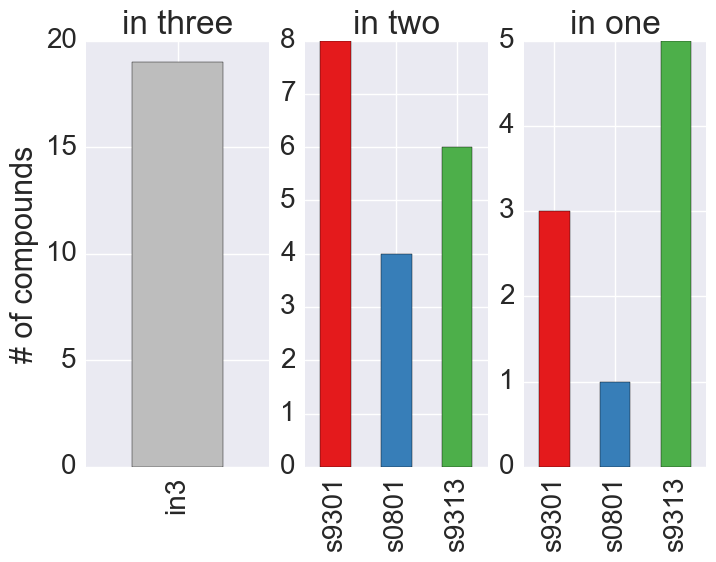

In [46]:
#count up the subsets for plotting (messy)
fi = cpd_inNstrains[cpd_inNstrains.loc[:,'in2']==1]
countSub = fi.sum(axis=0)

fi1 = cpd_inNstrains[cpd_inNstrains.loc[:,'in1']==1]
countSub1 = fi1.sum(axis=0)

pStrains = ['s9301','s0801','s9313']
useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors
fig,axs = plt.subplots(1,3)
sumCount.loc[['in3']].plot(kind = 'bar',ax=axs[0],color = '#bdbdbd')
axs[0].set_title('in three')
axs[0].set_ylabel('# of compounds')

countSub.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title('in two')
countSub1.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[2])
axs[2].set_title('in one')
fig.savefig('compoundsSBin3_filters.jpg')

In [47]:
gI = fi1.index

for item in gI:
    if fi1.loc[item,'s9301']==1:
        print(kegg_list(item).read())

cpd:C00147	Adenine; 6-Aminopurine

cpd:C00212	Adenosine

cpd:C00105	UMP; Uridylic acid; Uridine monophosphate; Uridine 5'-monophosphate; 5'Uridylic acid



In [48]:
for item in gI:
    if fi1.loc[item,'s0801']==1:
        print(kegg_list(item).read())

cpd:C00568	4-Aminobenzoate; ABEE; 4-Aminobenzoic acid; p-Aminobenzoate



In [49]:
for item in gI:
    if fi1.loc[item,'s9313']==1:
        print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C00092	D-Glucose 6-phosphate; Glucose 6-phosphate; Robison ester

cpd:C00123	L-Leucine; 2-Amino-4-methylvaleric acid; (2S)-alpha-2-Amino-4-methylvaleric acid; (2S)-alpha-Leucine

cpd:C00864	Pantothenate; Pantothenic acid; (R)-Pantothenate

cpd:C00106	Uracil



In [50]:
#go find all possible pathways for that compound

In [51]:
oneCpd='C01674'
r = kegg_link('pathway',oneCpd).read()
m = trimMap(r)

for item in m:
    print(kegg_list(item).read())

path:map00520	Amino sugar and nucleotide sugar metabolism

path:map01100	Metabolic pathways

path:map02010	ABC transporters

path:map02060	Phosphotransferase system (PTS)



Try extracellular, assume that if in genes, Pro will release it
---

In [52]:
#is a cpd in all three strains? or some lower number? ...extracellular
released_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0','s9301','s0801','s9313'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('extracellular_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            released_inNstrains.loc[oneCpd,st] = 1
    
    a = released_inNstrains.loc[oneCpd,strains].sum()

    if a == 3:
        released_inNstrains.loc[oneCpd,'in3'] = 1
    elif a == 2:
        released_inNstrains.loc[oneCpd,'in2'] = 1
    elif a == 1:
        released_inNstrains.loc[oneCpd,'in1'] = 1
    else: #will never have a=0 bc the if not r.empty statement
        released_inNstrains.loc[oneCpd,'in0'] = 1
        
sumCount_released = released_inNstrains.sum(axis=0)

In [53]:
r = released_inNstrains[released_inNstrains.loc[:,'in1'].gt(0)] #in 3...perhaps 'core' mtabs in Pro
for item in r.index:
    print(kegg_list(item).read())

cpd:C00147	Adenine; 6-Aminopurine

cpd:C01909	Dethiobiotin; Desthiobiotin

cpd:C00242	Guanine; 2-Amino-6-hydroxypurine

cpd:C01762	Xanthosine



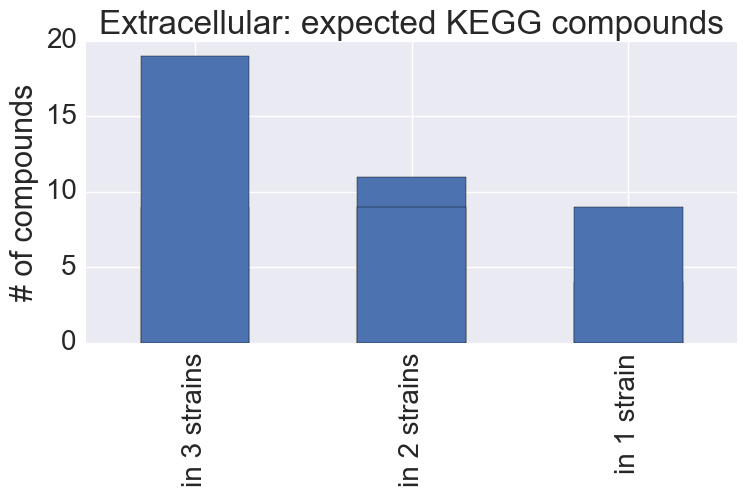

In [54]:
#remember - this is the subset of compounds I expect to find in all three strains...
#also...pre-screened to only be compounds we measured...this figure accounts for 
#anything with a value > 0
fig,axs = plt.subplots(1,1)
sumCount_released.loc[['in3','in2','in1']].plot(kind = 'bar')

sumCount.loc[['in3','in2','in1']].plot(kind = 'bar')
axs.set_title('Extracellular: expected KEGG compounds')
axs.set_ylabel('# of compounds')
tLabel = ['in 3 strains','in 2 strains','in 1 strain']
axs.set_xticklabels(tLabel)
plt.tight_layout()
plt.savefig('nCompounds_extracellular.jpg')

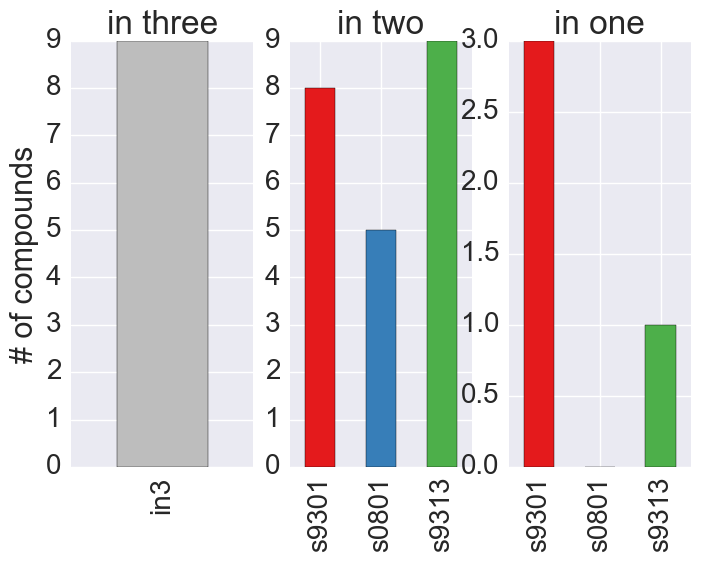

In [55]:
#count up the subsets for plotting (messy); extracellular
efi = released_inNstrains[released_inNstrains.loc[:,'in2']==1]
e_countSub = efi.sum(axis=0)

efi1 = released_inNstrains[released_inNstrains.loc[:,'in1']==1]
e_countSub1 = efi1.sum(axis=0)

useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors

fig,axs = plt.subplots(1,3)
sumCount_released.loc[['in3']].plot(kind = 'bar',ax=axs[0],color = '#bdbdbd')
axs[0].set_title('in three')
axs[0].set_ylabel('# of compounds')

e_countSub.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title('in two')
e_countSub1.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[2])
axs[2].set_title('in one')
fig.savefig('compoundsSBin3_extracellular.jpg')

In [56]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s0801']):
        pass
    else:
        #is in the list for strain?
        if item in prm_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [57]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate



In [58]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [59]:
oneCpd='C00954'
r = kegg_link('pathway',oneCpd).read()
m = trimMap(r)

for item in m:
    print(kegg_list(item).read())

path:map00380	Tryptophan metabolism

path:map01070	Biosynthesis of plant hormones

path:map01100	Metabolic pathways

path:map04075	Plant hormone signal transduction



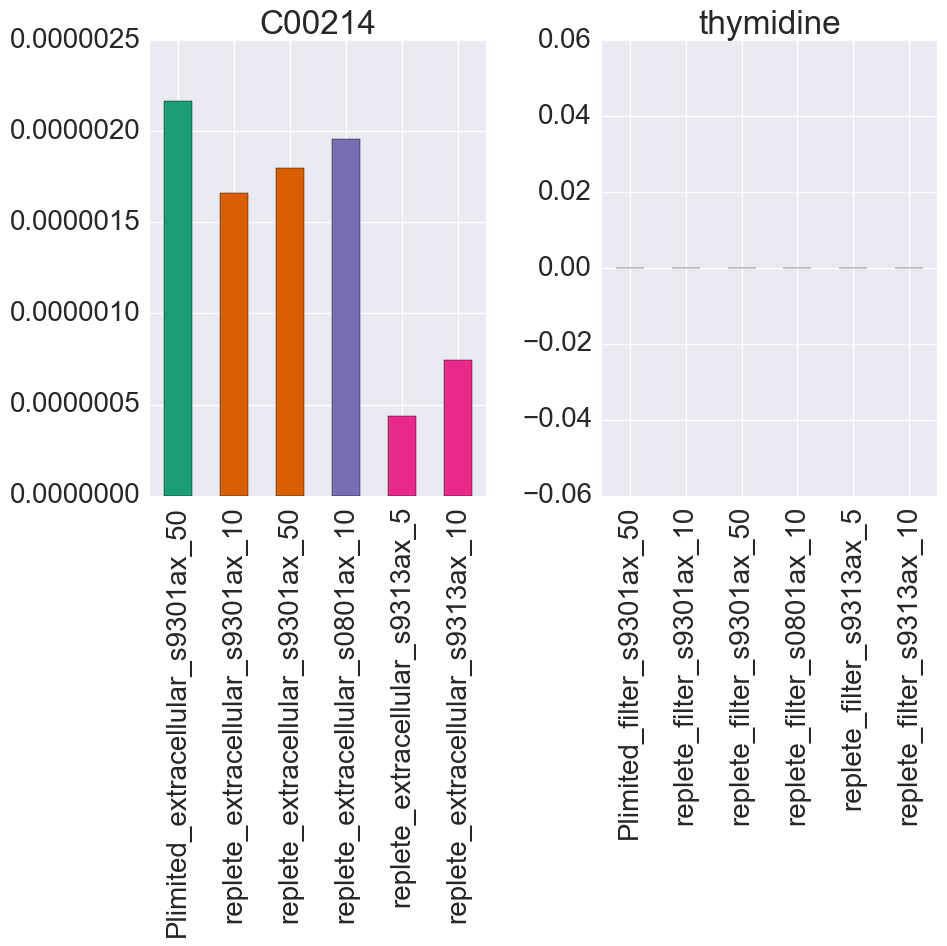

In [60]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
oneCpd = 'C00214'

fig,axs = plt.subplots(1,2)
df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[0])
plt.title(oneCpd)
axs[0].set_title(oneCpd)

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])

if True: #plot?
    #plt.gcf().subplots_adjust(bottom = .75)
    fig.set_size_inches(10,10)
    plt.tight_layout()
    #plt.savefig(oneCpd + '.png')

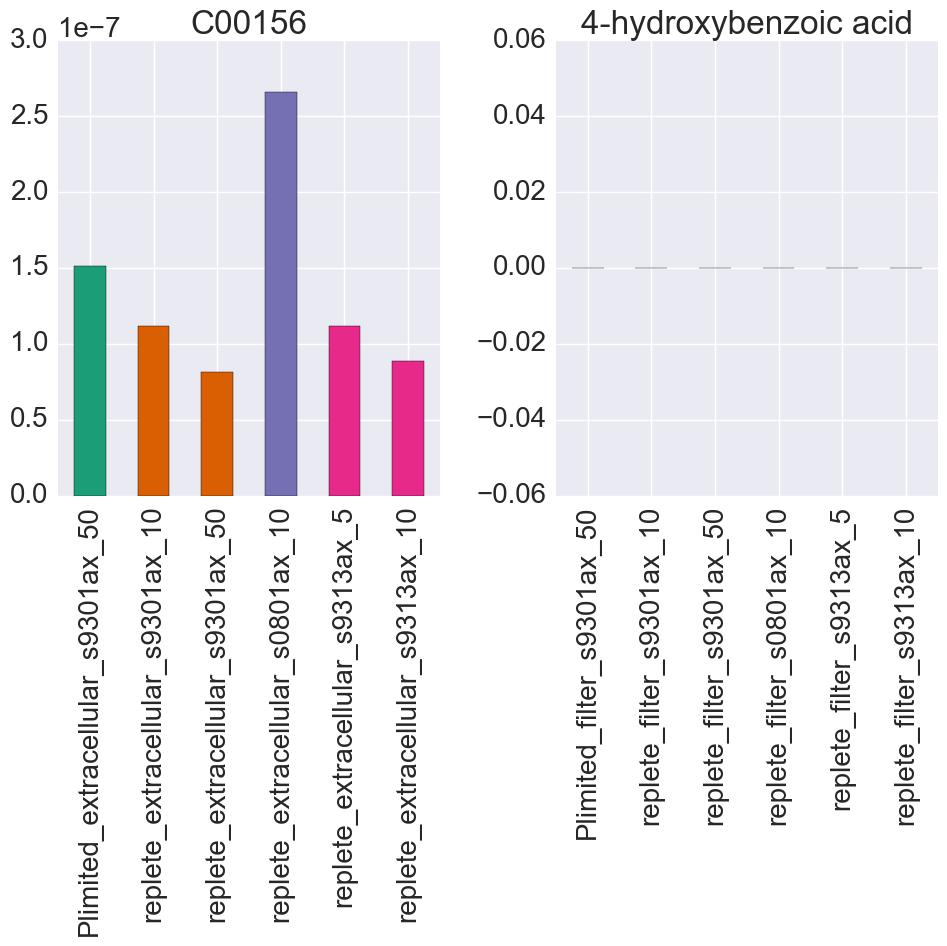

In [61]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
oneCpd = 'C00156'

fig,axs = plt.subplots(1,2)
df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[0])
plt.title(oneCpd)
axs[0].set_title(oneCpd)

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])

if True: #plot?
    #plt.gcf().subplots_adjust(bottom = .75)
    fig.set_size_inches(10,10)
    plt.tight_layout()
    #plt.savefig(oneCpd + '.png')

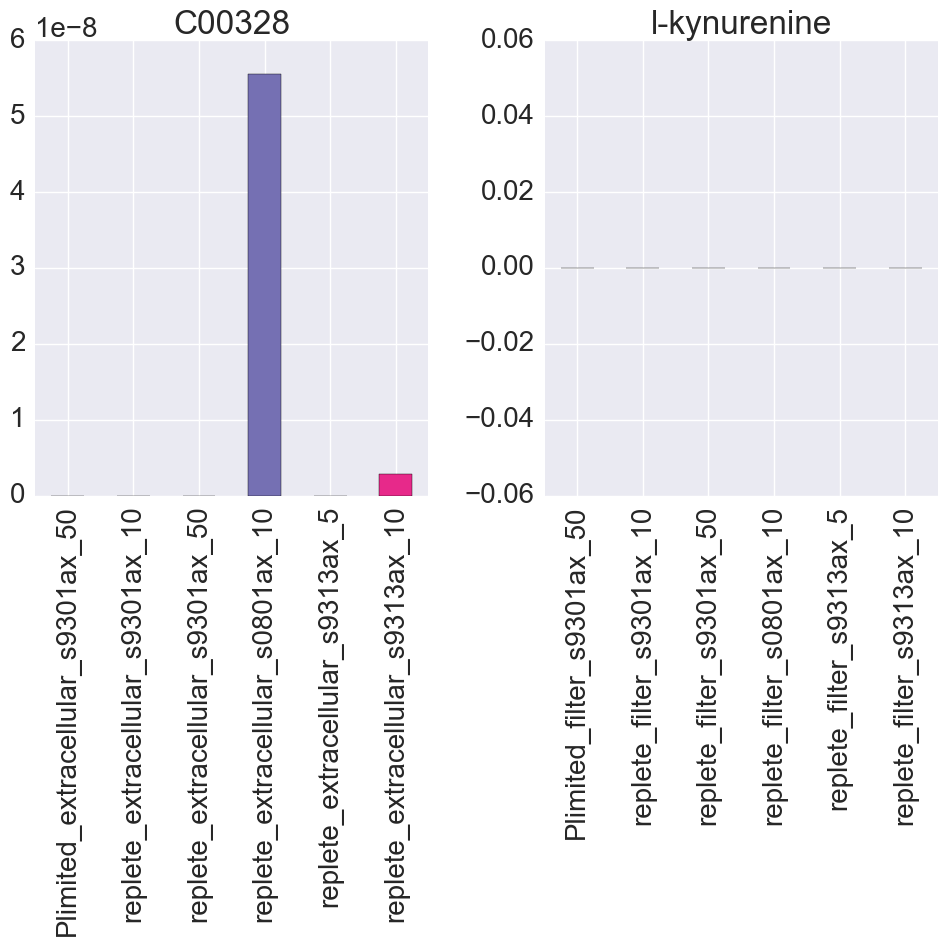

In [62]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
oneCpd = 'C00328'

fig,axs = plt.subplots(1,2)
df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[0])
plt.title(oneCpd)
axs[0].set_title(oneCpd)

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])

if True: #plot?
    #plt.gcf().subplots_adjust(bottom = .75)
    fig.set_size_inches(10,10)
    plt.tight_layout()
    #plt.savefig(oneCpd + '.png')

figure out the ratio of excreted / retained for each metabolite for each strain
---

In [63]:
ratEtoI = pd.DataFrame()
ratItoE = pd.DataFrame()

#for each filter...go find the matching extracellular
for item in list(mtabPruned.filter(regex = ('filter'))):
    #print(item)
    idx = [i for i in range(len(item)) if item.startswith('_',i)]
    toMatch = item[0:idx[0]] + '_extracellular' + item[idx[1]:len(item)]
    label = item[0:idx[0]] + item[idx[1]:len(item)]
    ratItoE.loc[:,label] = mtabPruned.loc[:,item]/mtabPruned.loc[:,toMatch]
    ratEtoI.loc[:,label] = mtabPruned.loc[:,toMatch]/mtabPruned.loc[:,item]      

In [64]:
#deal with Inf and NaN ...though there will be a pile of both which makes the analysis of this hard

In [65]:
temp = ratEtoI.replace(math.nan,0)
ratEtoIpruned = temp.loc[~(temp ==0).all(axis=1)]

In [66]:
temp = ratItoE.replace(math.nan,0)
ratItoEpruned = temp.loc[~(temp ==0).all(axis=1)]

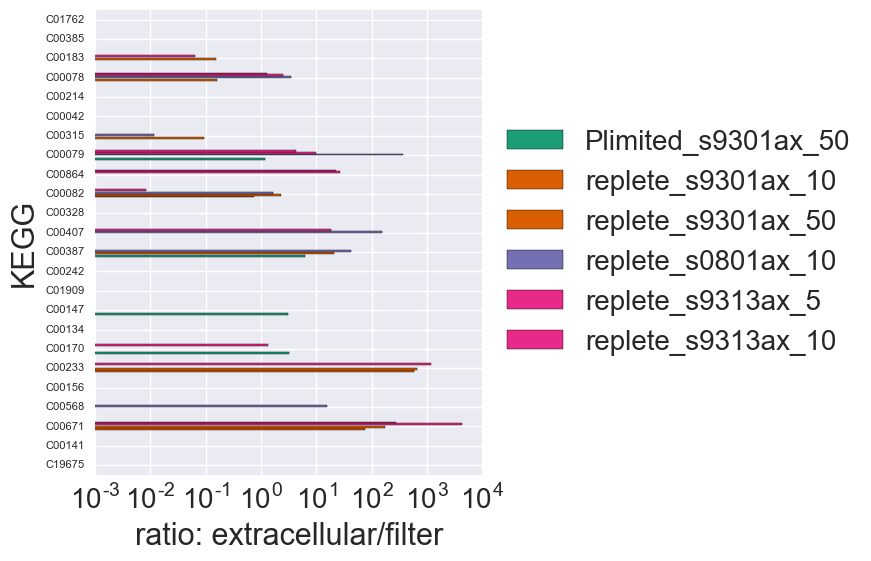

In [67]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']

axs = ratEtoIpruned.plot(kind = 'barh',color= useColors,figsize = (5,6))
#axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_xlabel('ratio: extracellular/filter')
axs.tick_params(axis = 'y',labelsize = 8)
axs.set_xscale('log')
axs.legend(loc = 'center left',bbox_to_anchor = (1,0.5))
# fig.savefig('nCompounds.jpg')
plt.show()

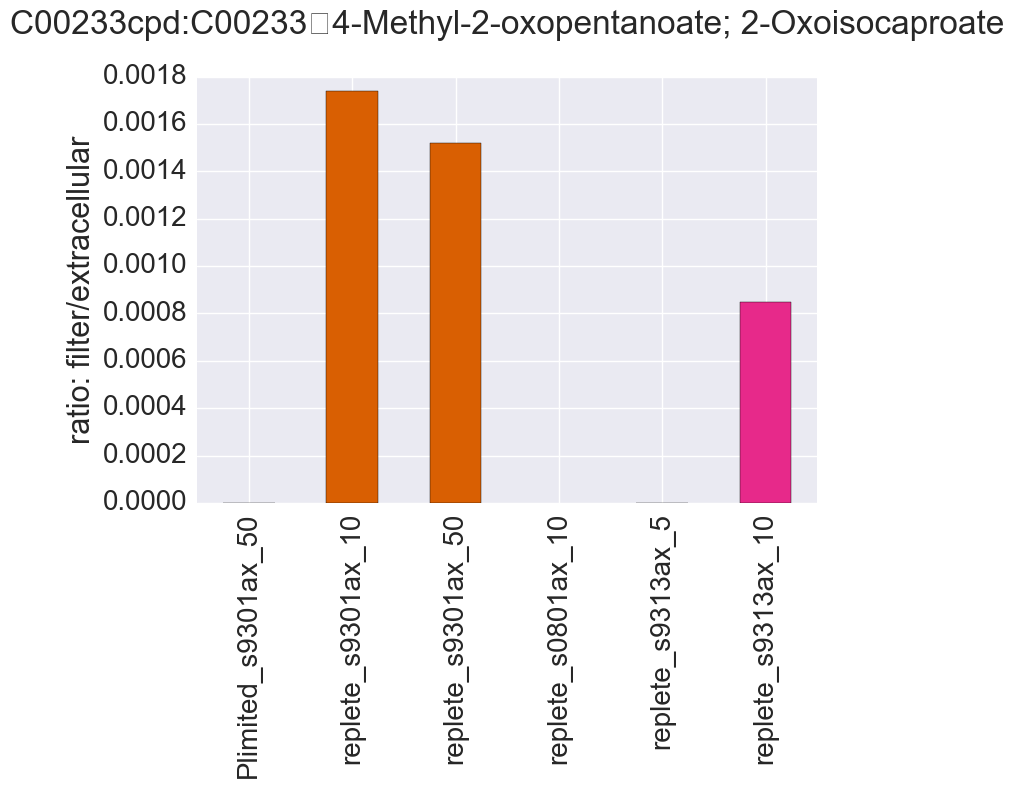

In [68]:
#plot one ratio
oneCpd = 'C00233'

useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = ratItoE.loc[oneCpd].plot(kind = 'bar',color= useColors)
axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('ratio: filter/extracellular')
# fig.savefig('nCompounds.jpg')
plt.show()

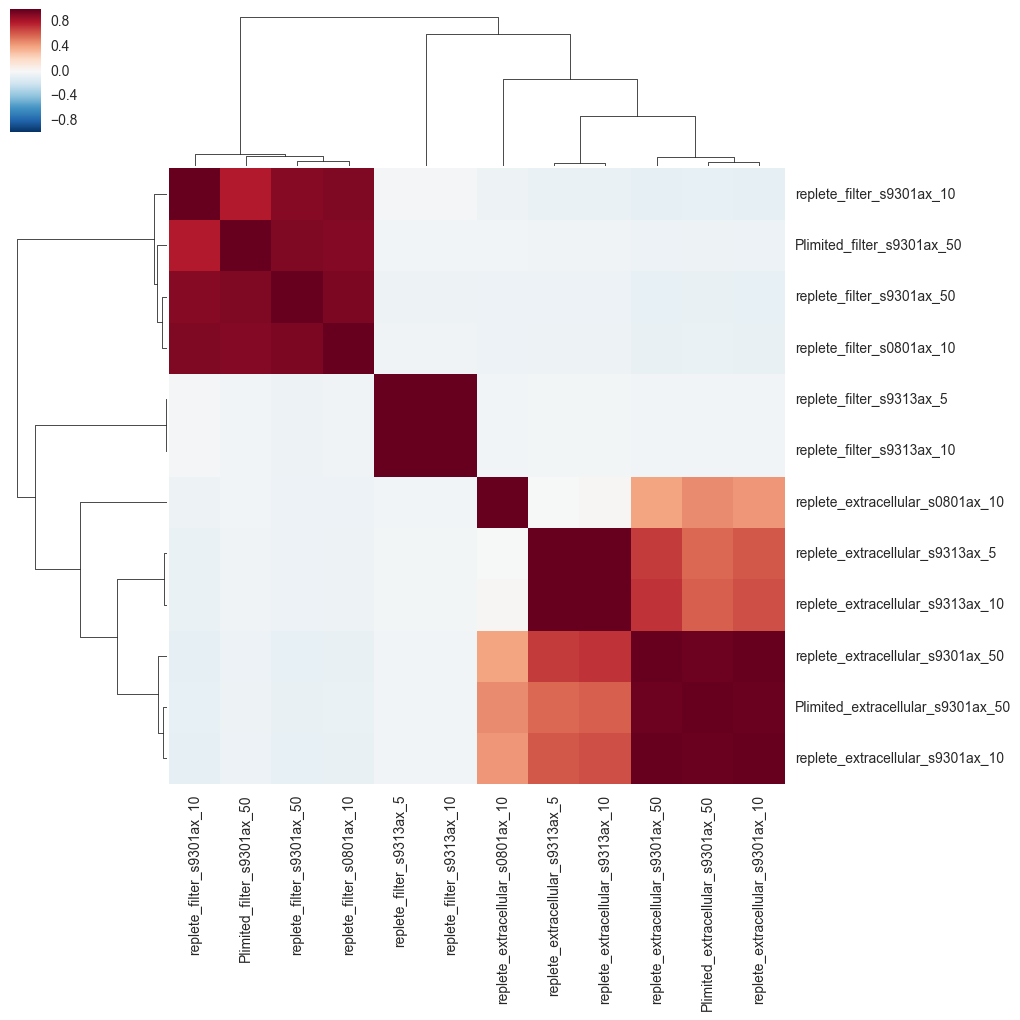

In [69]:
forCorr = mtabPruned.loc[~(mtabPruned ==0).all(axis=1)]
corr = forCorr.corr(method = 'pearson')

sns.set(font_scale=1)
g = sns.clustermap(corr,xticklabels = corr.columns,yticklabels = corr.columns)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
fig = plt.gcf()
#g.savefig('correlationAXsamples.jpg')
plt.show()

Consider how prevalent each compound is within KEGG
---

In [70]:
#already did this in the RI project, just adapt the code to count the compounds in the TSQ data set

In [71]:
countReactions = pd.DataFrame(useCO)
countReactions.insert(1,'nReactions',"")
countReactions.insert(1,'nPathways',"")

In [72]:
for idx in range(0,len(countReactions)):
    oneCpd = countReactions.ix[idx,'KEGG']
    rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
    countReactions.ix[idx,'nReactions'] = len(rnList.splitlines())
    
    #now go count the pathways
    rnList = kegg_link('pathway',oneCpd).read()
    countReactions.ix[idx,'nPathways'] = len(rnList.splitlines())

In [73]:
countReactions.sort_values(by = 'nReactions',ascending = False,inplace = True)
countReactions.reset_index(drop=True,inplace = True)
countReactions.head(4)

,KEGG,nPathways,nReactions
0,C00004,4,962
1,C00019,11,473
2,C00021,3,423
3,C00026,35,244


In [74]:
#investigate one compound
oneCpd = 'C00004'

In [75]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('pathway',oneCpd).read() #now go get the compounds for that reaction
print(len(rnList.splitlines()))

4


In [76]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
print(len(rnList.splitlines()))

962


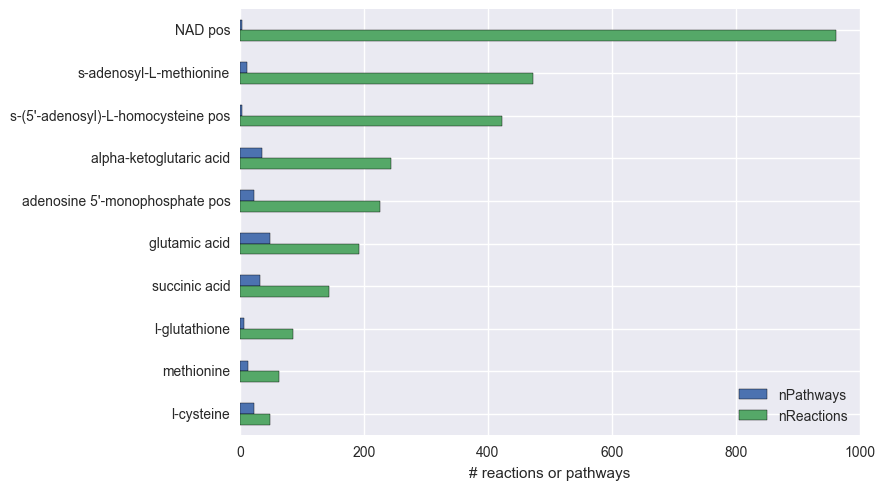

In [77]:
use = range(0,10)
labels = countReactions.ix[use,'KEGG']
tData = countReactions.ix[use]
#ax = tData.plot(kind = 'barh',x = tData['KEGG'])
axs = tData.plot(kind = 'barh',x = mtabNames.loc[tData.loc[:,'KEGG'],'mtabNames'])
fig = plt.gcf()
plt.xlabel('# reactions or pathways')
plt.ylabel('')
plt.gca().invert_yaxis()
plt.savefig('Pro_topTen.png',bbox_inches='tight')

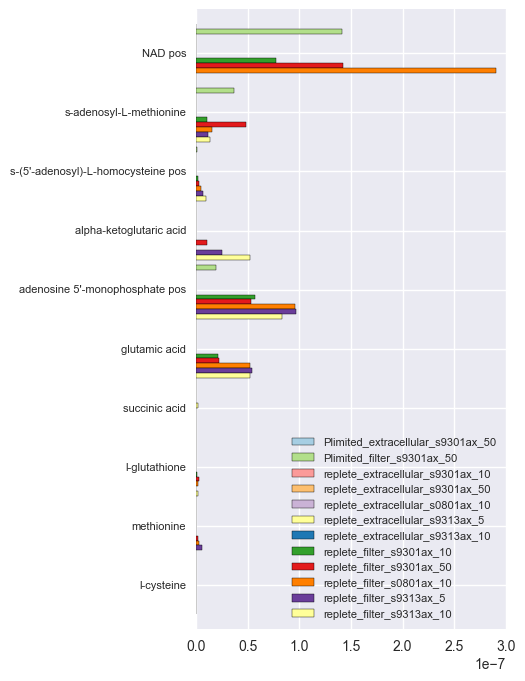

In [78]:
#plot filters and extracellular for the top 10 mtabs
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

axs = mtabPruned.loc[labels].plot(kind = 'barh',color= useColors,figsize = (4,8),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
# fig.savefig('nCompounds.jpg')
#axs.legend(loc = 'center right',bbox_to_anchor = (2,0.5))
plt.legend(loc=0,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

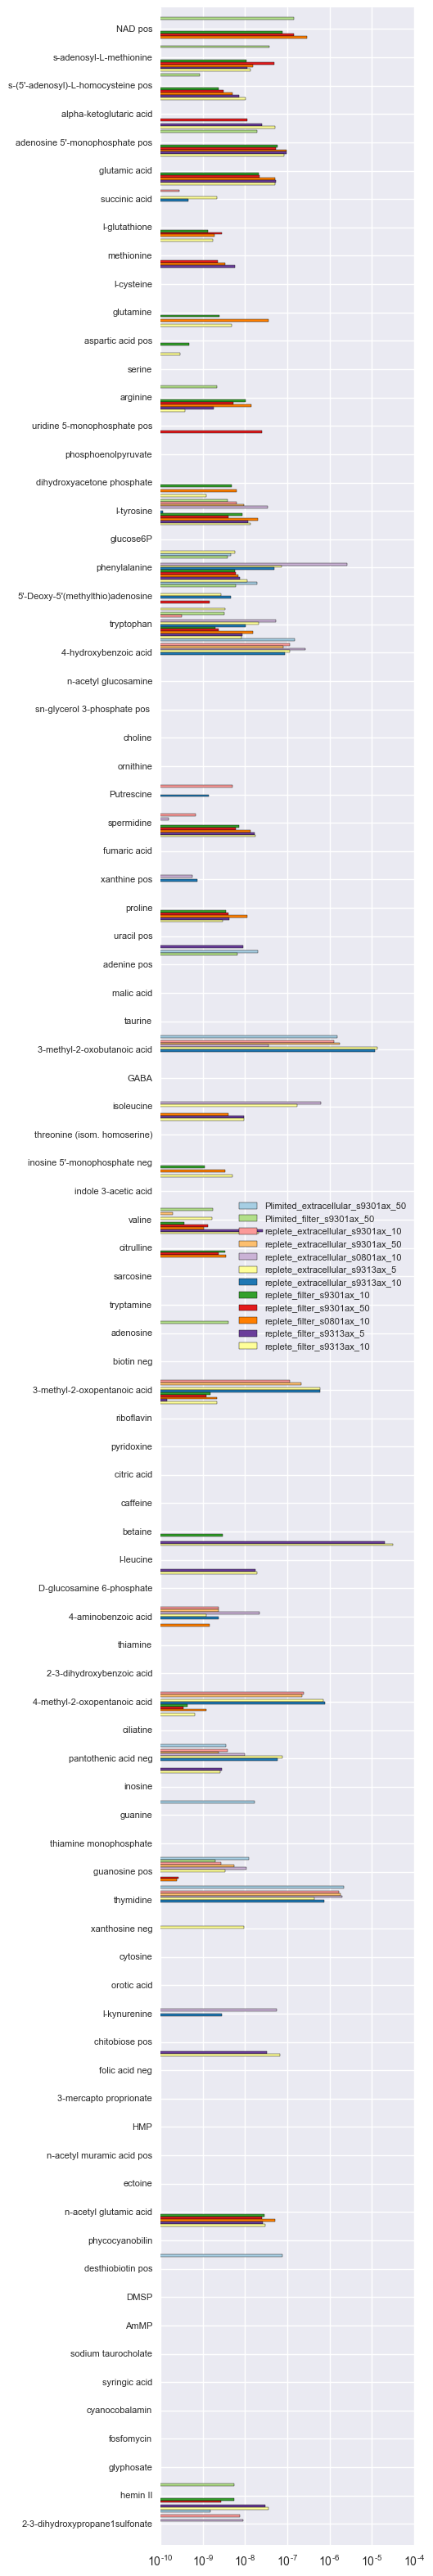

In [79]:
#...plot all (crazy large figure)
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,89)
labels = countReactions.ix[use,'KEGG']

axs = mtabPruned.loc[labels].plot(kind = 'barh',color= useColors,figsize = (4,40),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
#axs.legend(loc = 'center right',bbox_to_anchor = (2,0.5))
plt.legend(loc=0,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

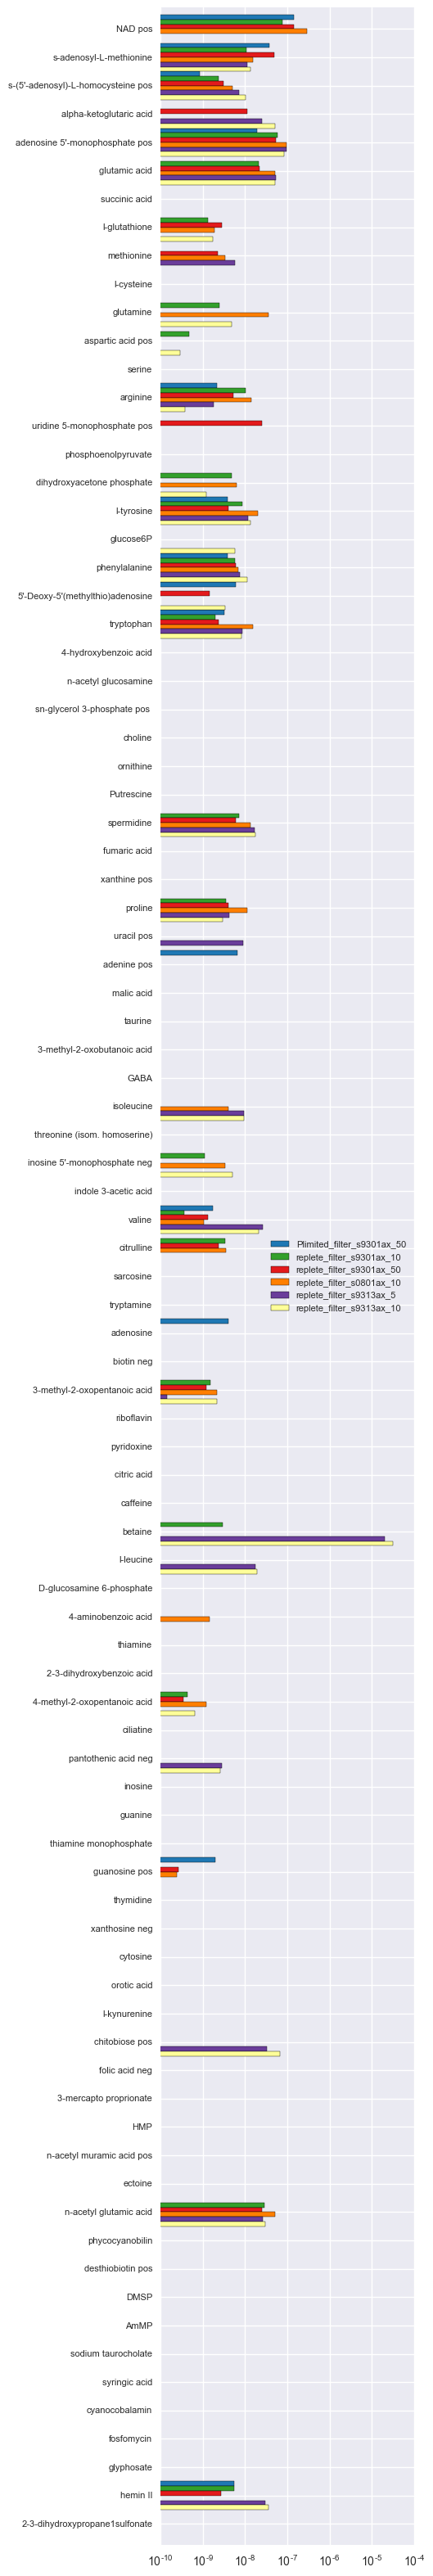

In [80]:
#...just plot the filter data
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,89)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('filter_'))

axs = toPlot.plot(kind = 'barh',color= useColors[6:12],figsize = (4,40),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

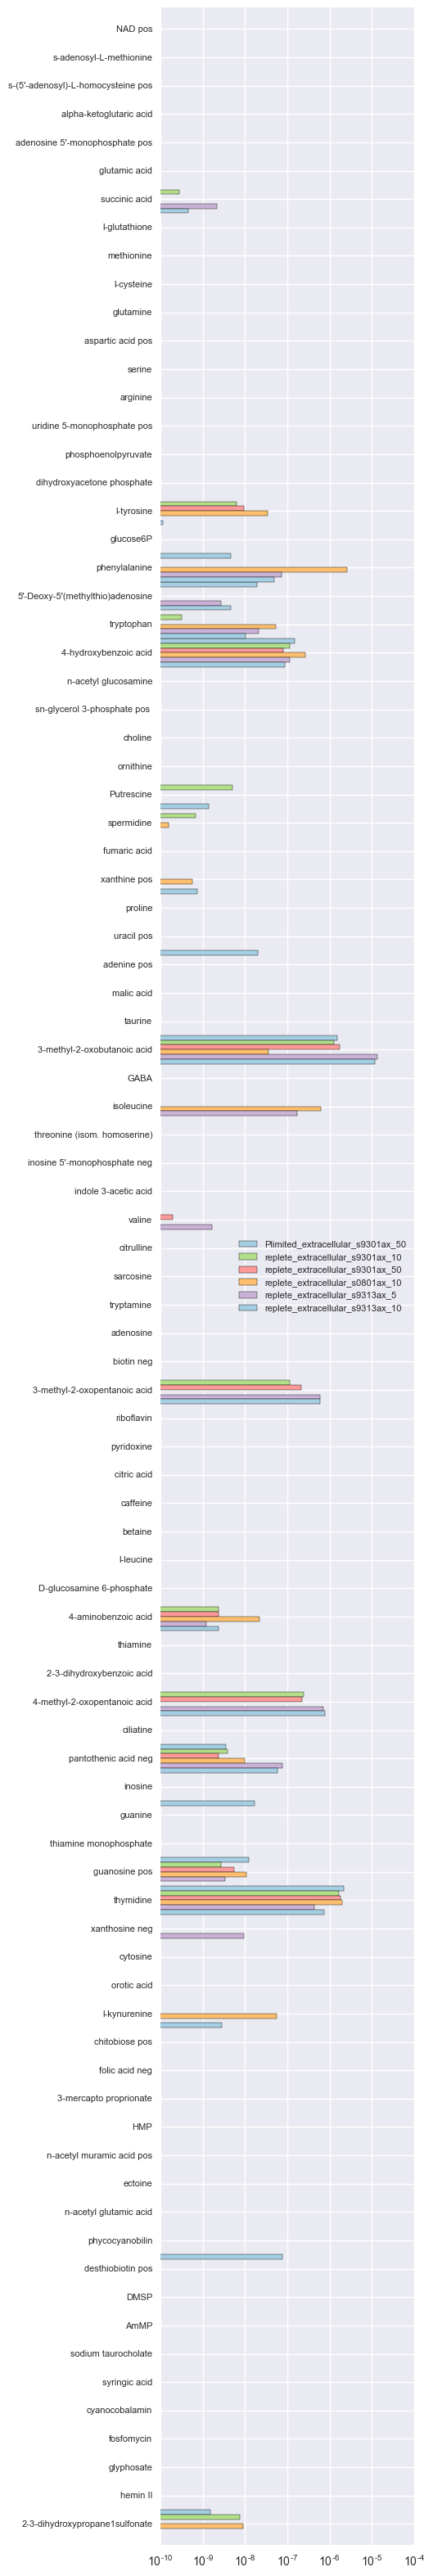

In [81]:
#this is not the best test bc bias in extraction efficiency
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,89)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('extracellular_'))

axs = toPlot.plot(kind = 'barh',color= useColors[0:5],figsize = (4,40),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

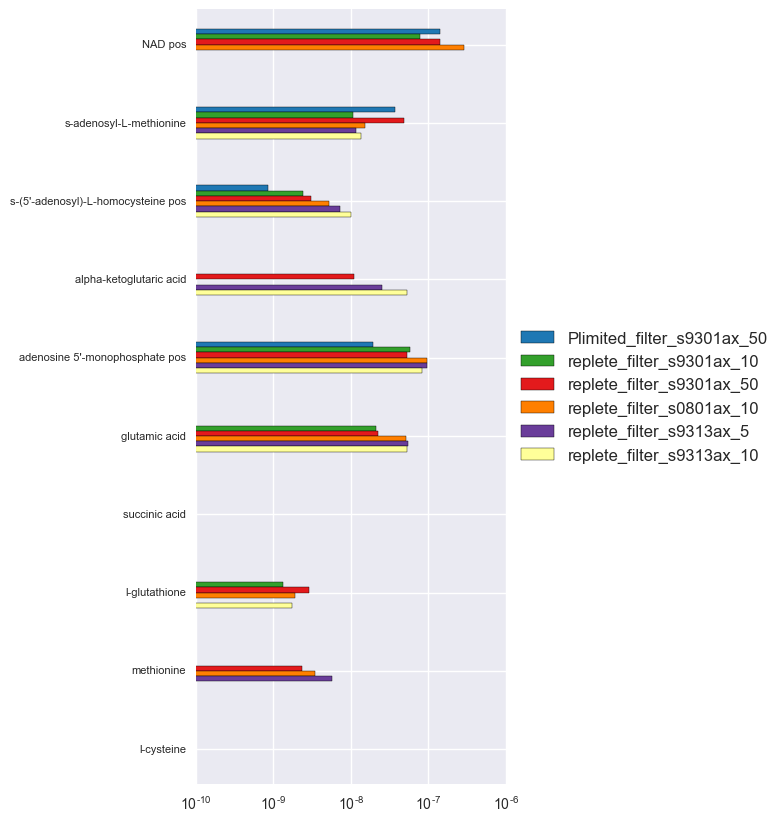

In [82]:
#...such a skew in amounts that most things end up as nothing when plotted as ordered in KEGG
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,10)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('filter_'))

axs = toPlot.plot(kind = 'barh',color= useColors[6:12],figsize = (4,10),width=0.4)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
axs.legend(loc = 'center left',bbox_to_anchor = (1,0.5),fontsize = 12)

#plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

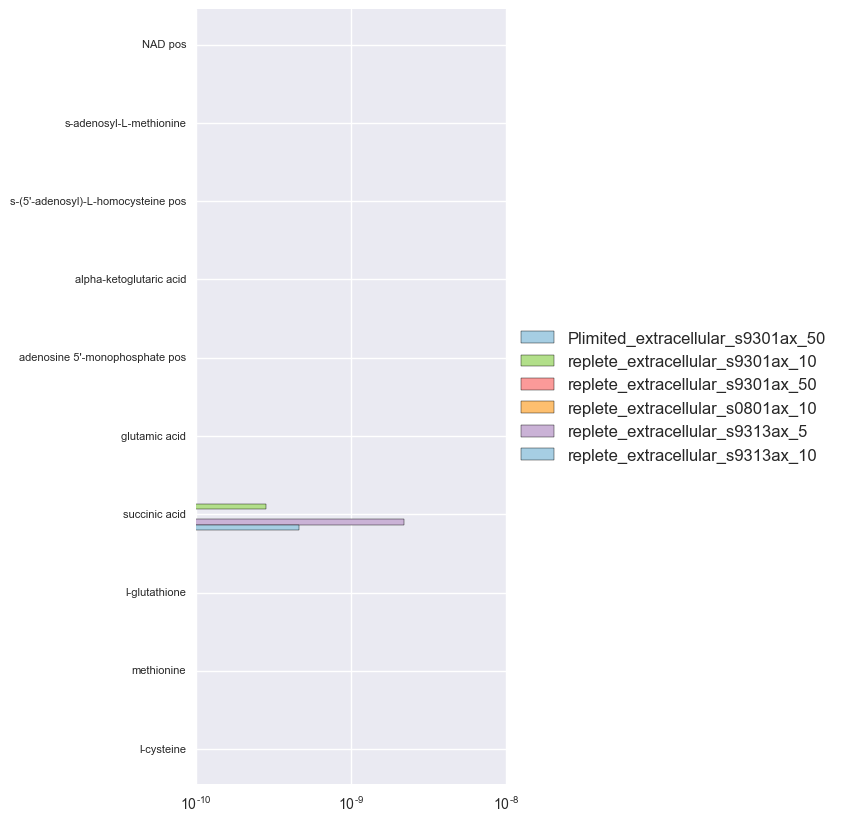

In [83]:
#...such a skew in amounts that most things end up as nothing when plotted as ordered in KEGG
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,10)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('extracellular_'))

axs = toPlot.plot(kind = 'barh',color= useColors[0:5],figsize = (4,10),width=0.4)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
axs.legend(loc = 'center left',bbox_to_anchor = (1,0.5),fontsize = 12)

#plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

In [84]:
# plot compounds by groups
useCO = mtabPruned.index
    
for item in prunedBRITE['map']:
    #usePathway = 'ko00020' #remember ko or pmg (not map)
    usePathway = 'ko' + item
     
    try: #KEGG does have pathways in BRITE list that are not searchable
        compounds = getCfrom_ko(usePathway) 

        #figure out which ones I have data for...
        setC = set(compounds)
        setT = set(useCO)
        intCompounds = setC.intersection(setT)

        if len(intCompounds)>0:

            fig,axs = plt.subplots(1,2)
            toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'extracellular')
            toPlot.plot(kind = 'barh',color = useColors,ax=axs[0])
            axs[0].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
            axs[0].set_xticklabels(axs[0].get_xticks().tolist(),fontsize = 8)
            axs[0].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
            axs[0].set_ylabel('')
            axs[0].set_title(usePathway,fontsize = 10)

            toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'filter')
            toPlot.plot(kind = 'barh',color = useColors,ax=axs[1])
            axs[1].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
            axs[1].set_xticklabels(axs[1].get_xticks().tolist(),fontsize = 8)
            axs[1].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
            axs[1].set_ylabel('')

            #probably a better way to do this
            tLabel = prunedBRITE[prunedBRITE.loc[:,'map']==usePathway[2:7]].reset_index()
            axs[1].set_title(tLabel.ix[0,'C'],fontsize = 10)

            if True: #plot?
                #plt.gcf().subplots_adjust(bottom = .75)
                fig.set_size_inches(10,5)
                plt.tight_layout()
                plt.savefig('pathways_withCompounds/' + usePathway + '.png')
                plt.close()
    except:
        print(usePathway + ': in BRITE, but not searchable at KEGG')

ko00351: in BRITE, but not searchable at KEGG
ko01010: in BRITE, but not searchable at KEGG
ko01060: in BRITE, but not searchable at KEGG
ko01061: in BRITE, but not searchable at KEGG
ko01062: in BRITE, but not searchable at KEGG
ko01063: in BRITE, but not searchable at KEGG
ko01064: in BRITE, but not searchable at KEGG
ko01065: in BRITE, but not searchable at KEGG
ko01066: in BRITE, but not searchable at KEGG
ko01070: in BRITE, but not searchable at KEGG
ko07011: in BRITE, but not searchable at KEGG
ko07012: in BRITE, but not searchable at KEGG
ko07013: in BRITE, but not searchable at KEGG
ko07021: in BRITE, but not searchable at KEGG
ko07019: in BRITE, but not searchable at KEGG
ko07020: in BRITE, but not searchable at KEGG
ko07014: in BRITE, but not searchable at KEGG
ko07023: in BRITE, but not searchable at KEGG
ko07026: in BRITE, but not searchable at KEGG
ko07044: in BRITE, but not searchable at KEGG
ko07053: in BRITE, but not searchable at KEGG
ko07040: in BRITE, but not searcha

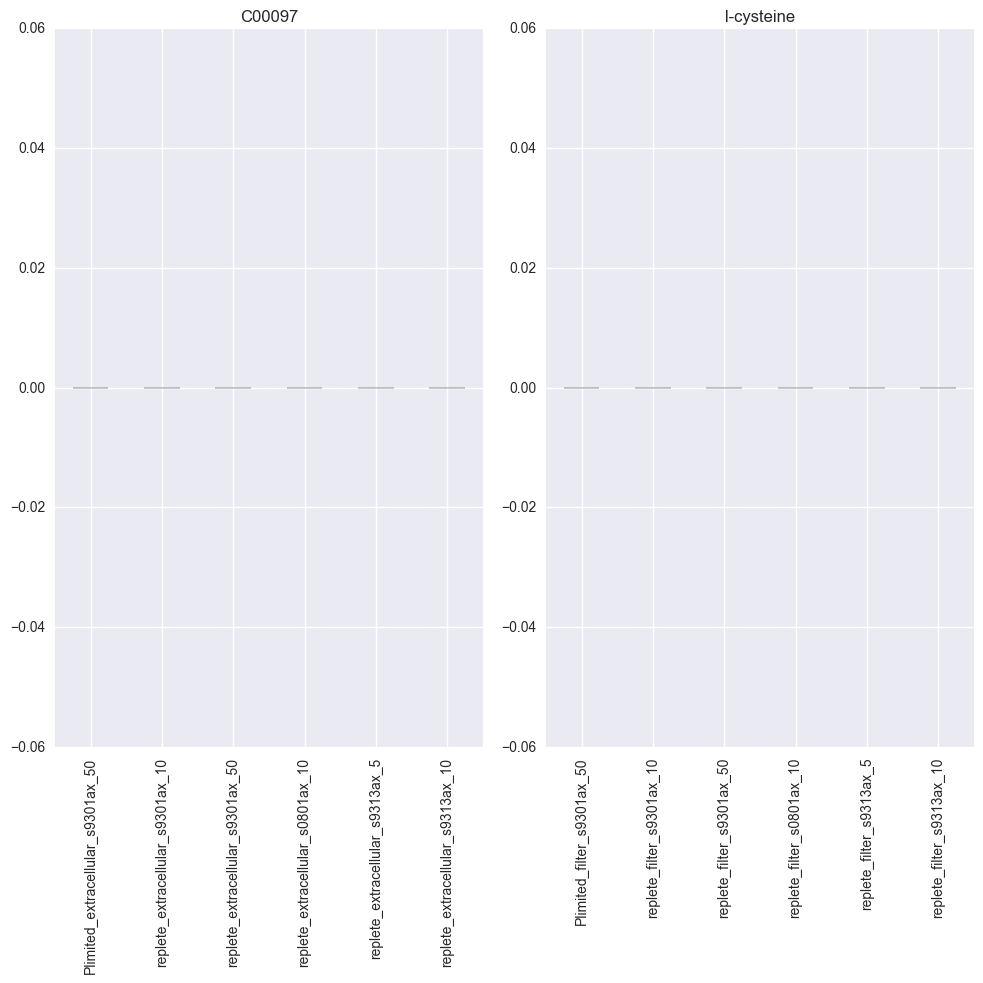

In [85]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
oneCpd = 'C00097'

fig,axs = plt.subplots(1,2)
df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[0])
plt.title(oneCpd)
axs[0].set_title(oneCpd)

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])

if True: #plot?
    #plt.gcf().subplots_adjust(bottom = .75)
    fig.set_size_inches(10,10)
    plt.tight_layout()
    #plt.savefig(oneCpd + '.png')

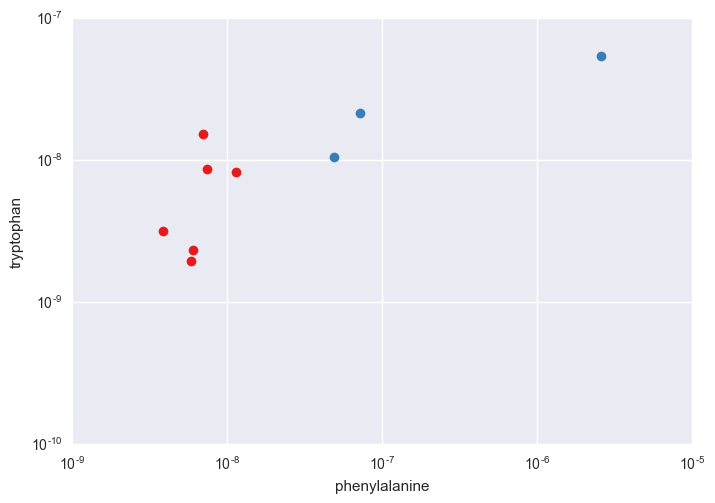

In [86]:
#consider specific pairs of compounds
cpd_phe = 'C00079'
cpd_tyr = 'C00082'
cpd_trp = 'C00078'

a = mtabPruned.loc[cpd_tyr,:]
b = mtabPruned.loc[cpd_phe,:]
c = mtabPruned.loc[cpd_trp,:]

twoColors = ['#e41a1c','#377eb8']

fig,axs = plt.subplots()
plt.plot(b.filter(regex = 'filter'),c.filter(regex = 'filter'),'o',color = twoColors[0])
plt.plot(b.filter(regex = 'extracellular'),c.filter(regex = 'extracellular'),'o',color = twoColors[1])

axs.set_xscale('log')
axs.set_xlabel(mtabNames.loc[cpd_phe,'mtabNames'])

axs.set_yscale('log')
axs.set_ylabel(mtabNames.loc[cpd_trp,'mtabNames'])

plt.show()

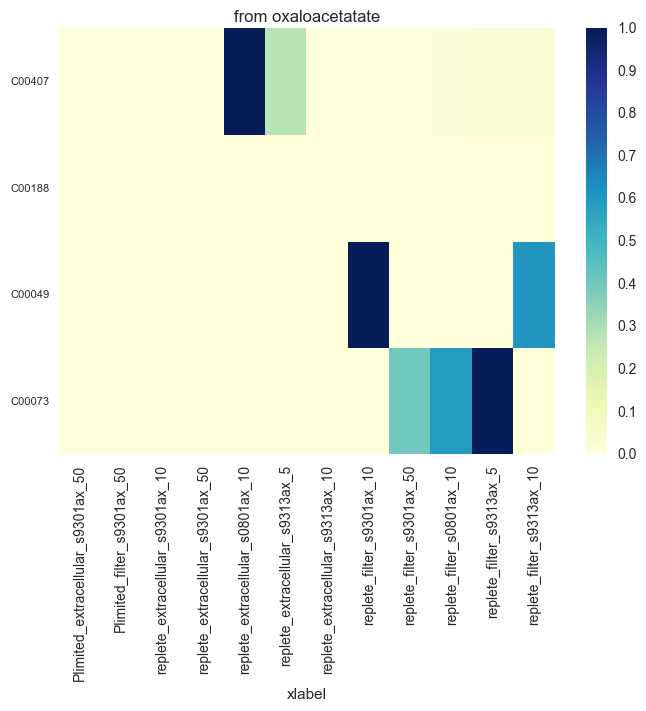

In [87]:
fromOA = ['C00073','C00049','C00188','C00407']

gatherGroup = mtabPruned.loc[fromOA,:]
scaled = preprocessing.minmax_scale(gatherGroup,feature_range=(0,1),axis = 1,copy=True)
#get row/column labels back
df = pd.DataFrame(scaled,columns = gatherGroup.columns,index = gatherGroup.index) 

plt.title('from oxaloacetatate')
plt.xlabel('xlabel')
plt.pcolor(df,cmap = 'YlGnBu')
plt.yticks(np.arange(0.5, len(gatherGroup.index), 1), gatherGroup.index,fontsize = 8)
plt.xticks(np.arange(0.5,(len(list(mtabPruned)) + 0.1),1), gatherGroup.columns,rotation = 90)
#plt.tight_layout()
fig = plt.gcf()
#fig.set_size_inches(18.5, 13)
#fig.savefig('temp' + '.png', dpi=100)
plt.colorbar()
plt.show()

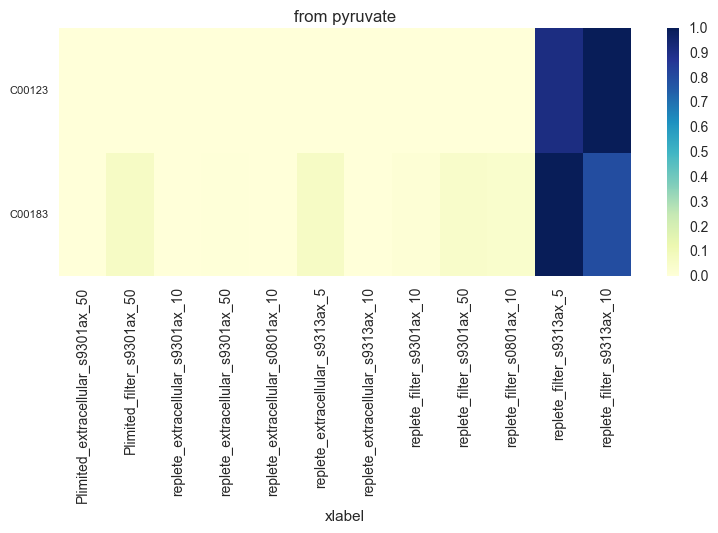

In [88]:
fromOA = ['C00183','C00123']

gatherGroup = mtabPruned.loc[fromOA,:]
scaled = preprocessing.minmax_scale(gatherGroup,feature_range=(0,1),axis = 1,copy=True)
#get row/column labels back
df = pd.DataFrame(scaled,columns = gatherGroup.columns,index = gatherGroup.index) 

plt.title('from pyruvate')
plt.xlabel('xlabel')
plt.pcolor(df,cmap = 'YlGnBu')
plt.yticks(np.arange(0.5, len(gatherGroup.index), 1), gatherGroup.index,fontsize = 8)
plt.xticks(np.arange(0.5,(len(list(mtabPruned)) + 0.1),1), gatherGroup.columns,rotation = 90)
plt.tight_layout()
fig = plt.gcf()
#fig.set_size_inches(18.5, 13)
fig.savefig('temp' + '.png', dpi=100)
plt.colorbar()
plt.show()

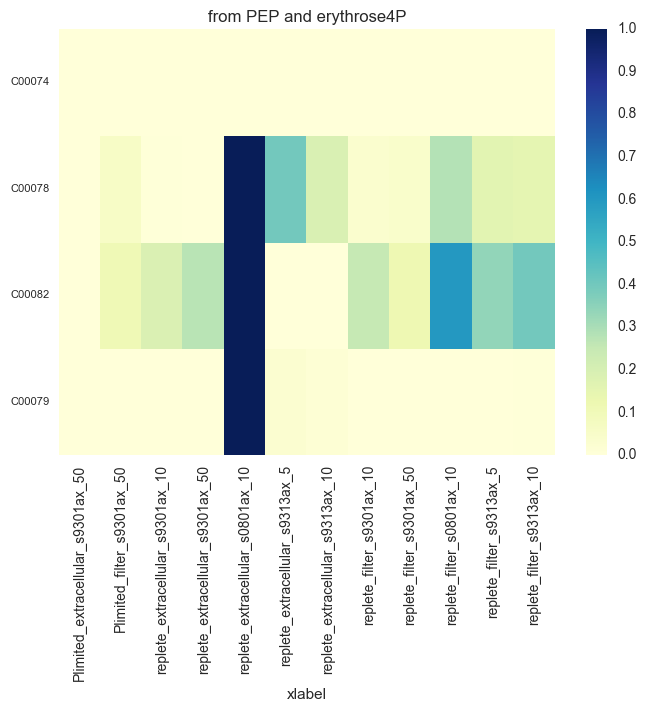

In [89]:
fromOA = ['C00079','C00082','C00078','C00074']

gatherGroup = mtabPruned.loc[fromOA,:]
scaled = preprocessing.minmax_scale(gatherGroup,feature_range=(0,1),axis = 1,copy=True)
#get row/column labels back
df = pd.DataFrame(scaled,columns = gatherGroup.columns,index = gatherGroup.index) 

plt.title('from PEP and erythrose4P')
plt.xlabel('xlabel')
plt.pcolor(df,cmap = 'YlGnBu')
plt.yticks(np.arange(0.5, len(gatherGroup.index), 1), gatherGroup.index,fontsize = 8)
plt.xticks(np.arange(0.5,(len(list(mtabPruned)) + 0.1),1), gatherGroup.columns,rotation = 90)
fig = plt.gcf()
#fig.set_size_inches(18.5, 13)
fig.savefig(oneGroup + '.png', dpi=100)
plt.colorbar()
plt.show()

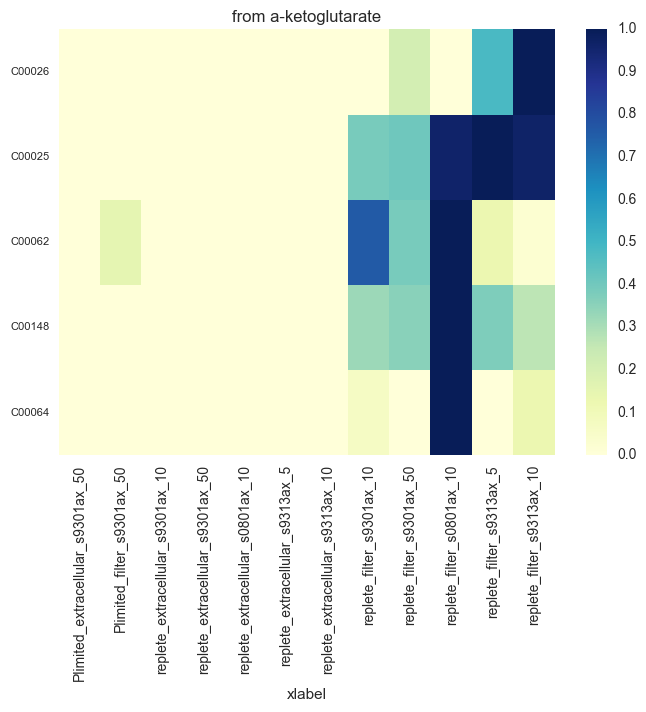

In [90]:
fromOA = ['C00064','C00148','C00062','C00025','C00026']

gatherGroup = mtabPruned.loc[fromOA,:]
scaled = preprocessing.minmax_scale(gatherGroup,feature_range=(0,1),axis = 1,copy=True)
#get row/column labels back
df = pd.DataFrame(scaled,columns = gatherGroup.columns,index = gatherGroup.index) 

plt.title('from a-ketoglutarate')
plt.xlabel('xlabel')
plt.pcolor(df,cmap = 'YlGnBu')
plt.yticks(np.arange(0.5, len(gatherGroup.index), 1), gatherGroup.index,fontsize = 8)
plt.xticks(np.arange(0.5,(len(list(mtabPruned)) + 0.1),1), gatherGroup.columns,rotation = 90)
fig = plt.gcf()
#fig.set_size_inches(18.5, 13)
fig.savefig(oneGroup + '.png', dpi=100)
plt.colorbar()
plt.show()

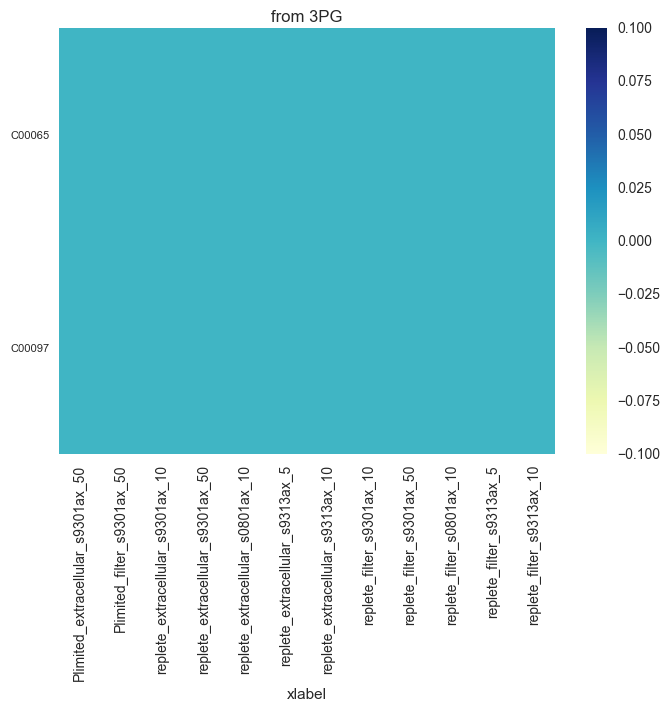

In [91]:
fromOA = ['C00097','C00065']

gatherGroup = mtabPruned.loc[fromOA,:]
scaled = preprocessing.minmax_scale(gatherGroup,feature_range=(0,1),axis = 1,copy=True)
#get row/column labels back
df = pd.DataFrame(scaled,columns = gatherGroup.columns,index = gatherGroup.index) 

plt.title('from 3PG')
plt.xlabel('xlabel')
plt.pcolor(df,cmap = 'YlGnBu')
plt.yticks(np.arange(0.5, len(gatherGroup.index), 1), gatherGroup.index,fontsize = 8)
plt.xticks(np.arange(0.5,(len(list(mtabPruned)) + 0.1),1), gatherGroup.columns,rotation = 90)
fig = plt.gcf()
#fig.set_size_inches(18.5, 13)
#fig.savefig(oneGroup + '.png', dpi=100)
plt.colorbar()
plt.show()

In [92]:
import dill                            #pip install dill --user
filename= 'globalsave.pkl'
dill.dump_session(filename)

In [93]:
import dill
# and to load the session again:
dill.load_session('globalsave.pkl')

In [94]:
# leave debris below here for now, notebook will stop at the 'raise' 
# command here that will keep me from running cells 
# of code that are not meant to be connected
raise

RuntimeError: No active exception to reraise

In [ ]:
#make one bar graph for each pathway map...with all five sample sets (10 ? )

In [ ]:
from matplotlib.ticker import FuncFormatter

def tickformat(x):
    if int(x) == float(x):
        return str(int(x))
    else:
        return str(x) 
    
fmt = FuncFormatter(lambda x, pos: tickformat(x / 1))

In [ ]:
# #can plot one at a time
# useCO = mtabPruned.index
# #these are the data (or ratios to plot...)
# CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_50']
# fxn_plotPathway_v2.gatherDetails('pmg00410','testingFolder',useCO,CO_values)
useCO = mtabPruned.index
    
item = '00020'
#print(item)
#usePathway = 'ko00020' #remember ko or pmg (not map)
usePathway = 'ko' + item

#get the compounds 
compounds = getCfrom_ko(usePathway)

#figure out which ones I have data for...
setC = set(compounds)
setT = set(useCO)
intCompounds = setC.intersection(setT)

if len(intCompounds)>0:

    fig,axs = plt.subplots(1,2)
    toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'extracellular')
    toPlot.plot(kind = 'barh',color = useColors,ax=axs[0])
    #plt.title(oneCpd)
    #axs[0].set_title(oneCpd)
    axs[0].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
    axs[0].set_xticklabels(axs[0].get_xticks().tolist(),fontsize = 8)
    axs[0].xaxis.set_major_formatter(fmt) #from stackoverflow
    axs[0].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
    axs[0].set_ylabel('')
    axs[0].set_title(usePathway,fontsize = 10)
    axs[0].set_xlabel('cell-specific concentration (ng/cell)',fontsize=8)

    toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'filter')
    toPlot.plot(kind = 'barh',color = useColors,ax=axs[1])
    #axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])
    axs[1].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
    axs[1].set_xticklabels(axs[1].get_xticks().tolist(),fontsize = 8)
    axs[1].xaxis.set_major_formatter(fmt)
    axs[1].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
    axs[1].set_ylabel('')

    #probably a better way to do this
    tLabel = prunedBRITE[prunedBRITE.loc[:,'map']==usePathway[2:7]].reset_index()
    axs[1].set_title(tLabel.ix[0,'C'],fontsize = 10)

    if True: #plot?
        #plt.gcf().subplots_adjust(bottom = .75)
        fig.set_size_inches(10,5)
        plt.tight_layout()
        plt.savefig('pathways_withCompounds/' + usePathway + '.png')
        #plt.close()

In [ ]:
#test one...checking the data
oneCpd = 'C00123'

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = toPlot.plot(kind = 'bar',color = useColors)
axs.set_title(oneCpd)

if False: #plot?
    plt.savefig('fig.png',bbox_inches='tight') 
    #plt.tight_layout()
    #plt.savefig(oneCpd + '.png')

In [ ]:
toPlot